# Analysis of the beer data and building models for quality predictions
Igor Kraszewski

## The purpose of the project
The purpose of the project is to analyze the dataset about beers. Firstly, getting some important statistics, finding dependencies within data and vizualizing the most important of them. Subsequently, having this knowledge, building machine learning models with different algorithms for predicting beers' quality and compare them.

## Dataset
'Beer Profile and Ratings Data Set' is a dataset found on [Kaggle](https://www.kaggle.com/datasets/ruthgn/beer-profile-and-ratings-data-set?resource=download&select=beer_profile_and_ratings.csv) which contains tasting profiles and consumer reviews for 3197 unique beers from 934 different breweries.
The csv file we use contains following columns:
- Name - name of the beer
- Style - style of the beer
- Brewery - name of the brewery where the beer was made
- Beer Name (Full) - an unique identifier for each beer, full name of the beer (Name + Brewery)
- Description - Notes of the beer if available
- ABV - Alcohol by volume (in %)
- Min IBU - The minimum IBU (International Bitterness Units) value each beer can possess
- Max IBU - The maximum IBU (International Bitterness Units) value each beer can possess
<br>
***
Next columns which represent tasting profile features of the beer are defined by words count found in up to 25 reviews of each beer (The assumption is that people writing reviews are more than likely describing what they do experience rather than what they do not).
<br>Mouthfeel
- Astrigency
- Body
- Alcohol

<br>Taste
- Bitter
- Sweet
- Sour
- Salty

<br>Flavor and aroma
- Fruits
- Hoppy
- Spices
- Malty
<br>
***
Last columns are connected with consumer reviews of the beer.
- review_aroma - average score of the beer for its aroma
- review_appearance - average score of the beer for its appearance
- review_palete - average score of the beer for its palete
- review_taste - average score of the beer for its taste
- review_overall - average overall score of the beer
- number_of_reviews

In [2]:
# Loading necessary libraries
library("tidyverse")
library("caret")
library("scales")
library("gridExtra")
library("ggthemes")
library("randomForest")
library("data.table")
library("corrplot")
library('MLmetrics')
library("lolR")
library("GGally")
library('naivebayes')
options(digits=3)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Ładowanie wymaganego pakietu: lattice


Dołączanie pakietu: ‘caret’


Następujący obiekt został zakryty z ‘package:purrr’:

    lift



Dołączanie pakietu: ‘scales’


Następujący obiekt został zakryty z ‘package:purrr’:

    discard


Następujący obiekt został zakryty z ‘package:readr’:

    col_factor



Dołączanie pakietu: ‘gridExtra’


Następujący obiekt został zakryty z ‘package:dplyr’:

    combine


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Dołączanie pakietu: ‘randomForest’


Następujący obiekt został zakryty z ‘package:gridExtra’:

    combine


Następujący obiekt zos

In [3]:
file_name <- "beer_profile_and_ratings.csv"
# Check if our data have title row and what is the delimiter
read_lines(file_name, n_max = 3)

[1] "Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
[2] "Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,\"Notes:Richly malty and long on the palate, with just enough hop backing to make this beautiful amber colored \"\"alt\"\" style beer notably well balanced.\\t\",5.3,25,50,13,32,9,47,74,33,0,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
[3] "Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,\"Notes:This malty, full-bodied double alt is also known as “Stickebier” – German slang for “secret brew”. Long Trail Double Bag was originally offered only in our brewery taproom as a special treat to our visitors. With an alcohol content of 7.2%, please indulge in moderation. The Long Trail Brewing Company is proud to have Double Bag named Malt Advocate’s “Beer of the Year” in 2001. Malt Advocate is a national magazine devoted to “expanding the boundaries of fine drinks”. Their panel of judges likes to keep things simple, and therefore of thousands of eligible competitors they award only two categories: “Imported” and “Domestic”. It is a great honor to receive this recognition.33 IBU\\t\",7.2,25,50,12,57,18,33,55,16,0,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481"

As we can see the data contains tittle row and its delimeter is a comma.

In [4]:
data <- read_csv(file_name)
colnames(data) <- make.names(colnames(data))

Rows: 3197 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): Name, Style, Brewery, Beer Name (Full), Description
dbl (20): ABV, Min IBU, Max IBU, Astringency, Body, Alcohol, Bitter, Sweet, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
head(data)

Name                         Style  
1 Amber                        Altbier
2 Double Bag                   Altbier
3 Long Trail Ale               Altbier
4 Doppelsticke                 Altbier
5 Sleigh'r Dark Doüble Alt Ale Altbier
6 Sticke                       Altbier
  Brewery                                         
1 Alaskan Brewing Co.                             
2 Long Trail Brewing Co.                          
3 Long Trail Brewing Co.                          
4 Uerige Obergärige Hausbrauerei GmbH / Zum Uerige
5 Ninkasi Brewing Company                         
6 Uerige Obergärige Hausbrauerei GmbH / Zum Uerige
  Beer.Name..Full.                                                    
1 Alaskan Brewing Co. Alaskan Amber                                   
2 Long Trail Brewing Co. Double Bag                                   
3 Long Trail Brewing Co. Long Trail Ale                               
4 Uerige Obergärige Hausbrauerei GmbH / Zum Uerige Uerige Doppelsticke
5 Ninkasi Brewing Company Sleigh'r Dark Doüble Alt Ale                
6 Uerige Obergärige Hausbrauerei GmbH / Zum Uerige Uerige Sticke      
  Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1 Notes:Richly malty and long on the palate, with just enough hop backing to make this beautiful amber colored "alt" style beer notably well balanced.\\t                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2 Notes:This malty, full-bodied double alt is also known as “Stickebier” – German slang for “secret brew”. Long Trail Double Bag was originally offered only in our brewery taproom as a special treat to our visitors. With an alcohol content of 7.2%, please indulge in moderation. The Long Trail Brewing Company is proud to have Double Bag named Malt Advocate’s “Beer of the Year” in 2001. Malt Advocate is a national magazine devoted to “expanding the boundaries of fine drinks”. Their panel of judges likes to keep things simple, and therefore of thousands of eligible competitors they award only two categories: “Imported” and “Domestic”. It is a great honor to receive this recognition.33 IBU\\t
3 Notes:Long Trail Ale is a full-bodied amber ale modeled after the “Alt-biers” of Düsseldorf, Germany. Our top fermenting yeast and cold finishing temperature result in a complex, yet clean, full flavor. Originally introduced in November of 1989, Long Trail Ale beer quickly became, and remains, the largest selling craft-brew in Vermont. It is a multiple medal winner at the Great American Beer Festival.25 IBU\\t                                                                                                                                                                                                                                                                                          
4 Notes:                                                                           

In [6]:
# Getting more information about the structure of data object
str(data)

spec_tbl_df [3,197 × 25] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Name             : chr [1:3197] "Amber" "Double Bag" "Long Trail Ale" "Doppelsticke" ...
 $ Style            : chr [1:3197] "Altbier" "Altbier" "Altbier" "Altbier" ...
 $ Brewery          : chr [1:3197] "Alaskan Brewing Co." "Long Trail Brewing Co." "Long Trail Brewing Co." "Uerige Obergärige Hausbrauerei GmbH / Zum Uerige" ...
 $ Beer.Name..Full. : chr [1:3197] "Alaskan Brewing Co. Alaskan Amber" "Long Trail Brewing Co. Double Bag" "Long Trail Brewing Co. Long Trail Ale" "Uerige Obergärige Hausbrauerei GmbH / Zum Uerige Uerige Doppelsticke" ...
 $ Description      : chr [1:3197] "Notes:Richly malty and long on the palate, with just enough hop backing to make this beautiful amber colored \""| __truncated__ "Notes:This malty, full-bodied double alt is also known as “Stickebier” – German slang for “secret brew”. Long T"| __truncated__ "Notes:Long Trail Ale is a full-bodied amber ale modeled after the “Alt-biers” of Düsse

In [7]:
# Checking if columns of our data have any missing values
apply(data, 2, function(col) sum(is.na(col)))

Name             Style           Brewery  Beer.Name..Full. 
                0                 0                 0                 0 
      Description               ABV           Min.IBU           Max.IBU 
                0                 0                 0                 0 
      Astringency              Body           Alcohol            Bitter 
                0                 0                 0                 0 
            Sweet              Sour             Salty            Fruits 
                0                 0                 0                 0 
            Hoppy            Spices             Malty      review_aroma 
                0                 0                 0                 0 
review_appearance     review_palate      review_taste    review_overall 
                0                 0                 0                 0 
number_of_reviews 
                0

We can see that none of the columns have NA values in it.

## Analyse of the beers ratings

In [8]:
# Creating subset of data for analysing reviews
data_ratings <- data %>% dplyr::select(Name, Style, review_aroma:number_of_reviews)
# Getting basic statistics of the review columns
data_ratings %>% dplyr::select(review_aroma:number_of_reviews) %>% summary()

  review_aroma  review_appearance review_palate   review_taste  review_overall
 Min.   :1.51   Min.   :1.57      Min.   :1.29   Min.   :1.21   Min.   :1.14  
 1st Qu.:3.42   1st Qu.:3.60      1st Qu.:3.47   1st Qu.:3.50   1st Qu.:3.57  
 Median :3.72   Median :3.83      Median :3.74   Median :3.79   Median :3.83  
 Mean   :3.64   Mean   :3.75      Mean   :3.66   Mean   :3.70   Mean   :3.75  
 3rd Qu.:3.98   3rd Qu.:4.00      3rd Qu.:3.97   3rd Qu.:4.03   3rd Qu.:4.03  
 Max.   :5.00   Max.   :4.67      Max.   :5.00   Max.   :5.00   Max.   :5.00  
 number_of_reviews
 Min.   :   1     
 1st Qu.:  23     
 Median :  93     
 Mean   : 233     
 3rd Qu.: 284     
 Max.   :3290     

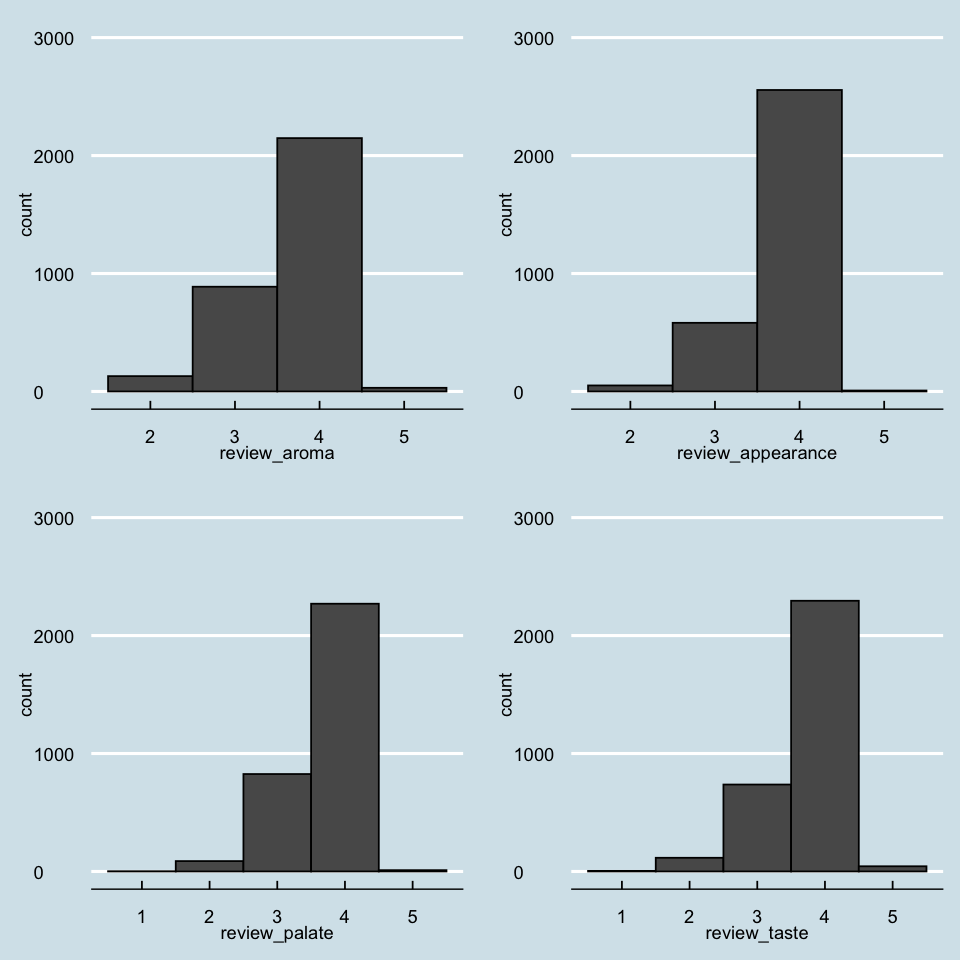

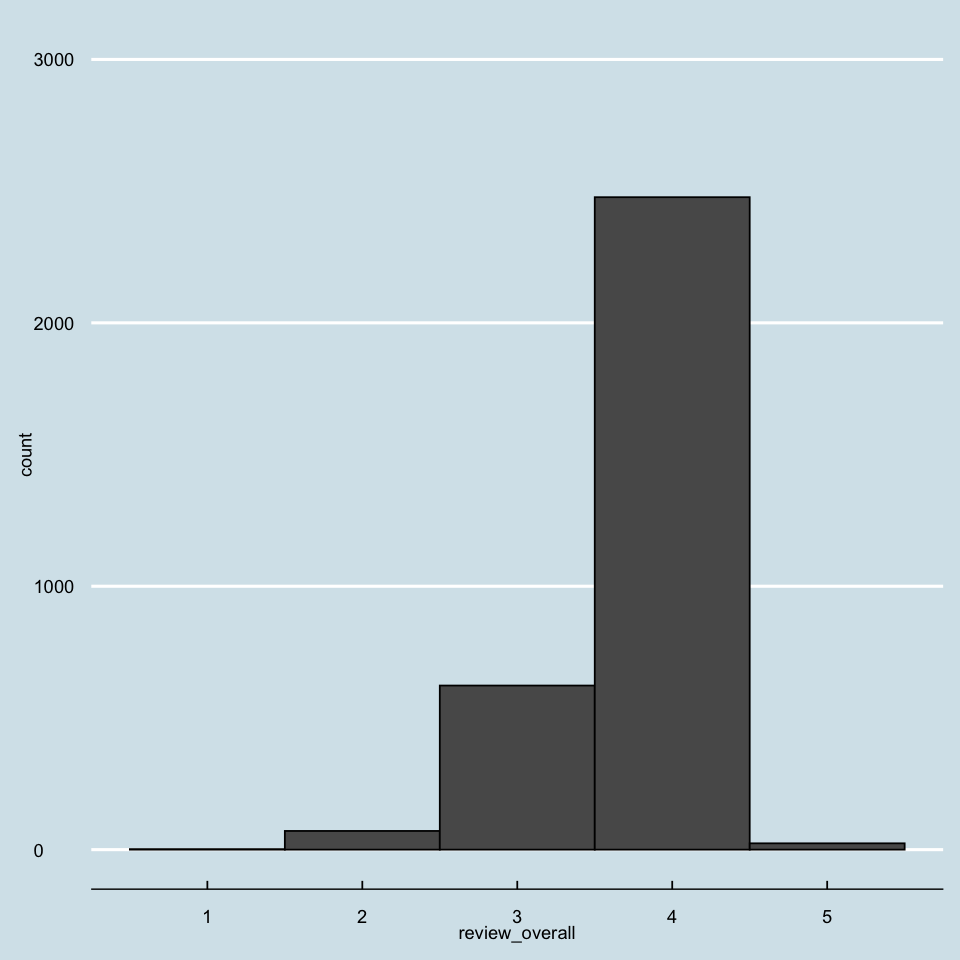

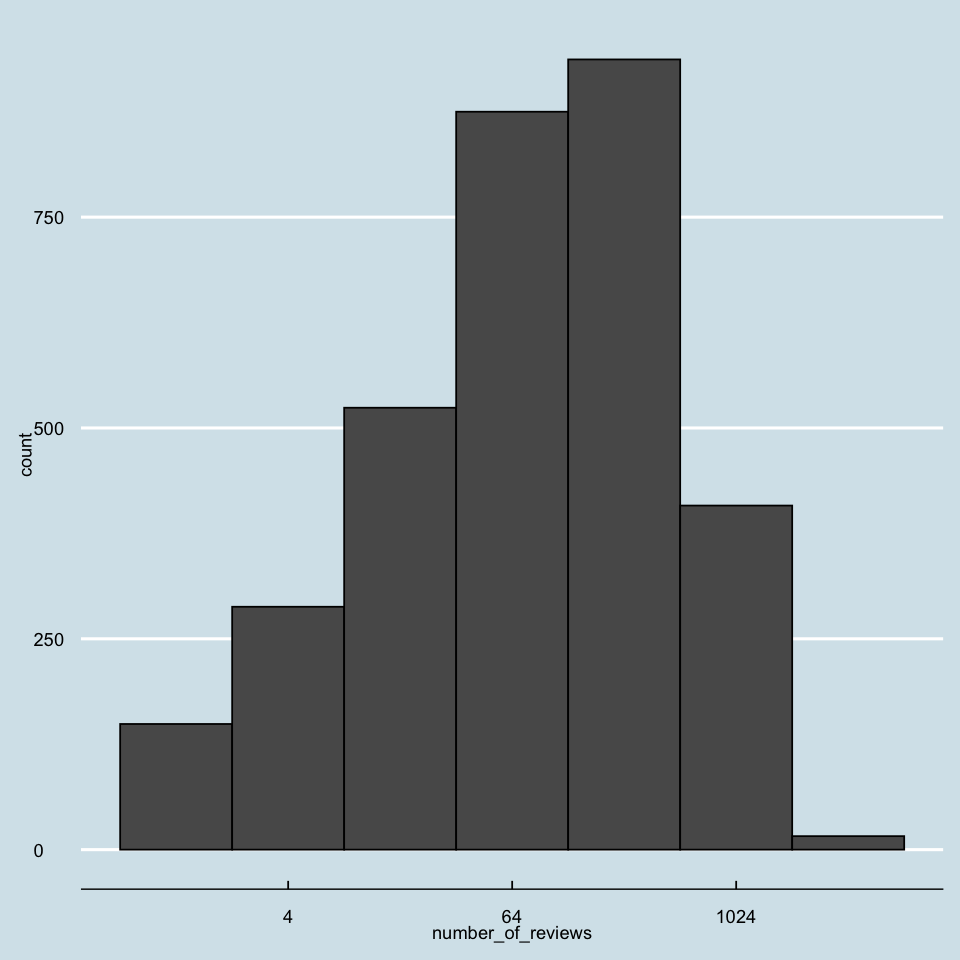

In [9]:
par(bg = 'white')
options(repr.plot.width=8, repr.plot.height=8)
overall <- data_ratings %>% ggplot(aes(review_overall)) + geom_histogram(binwidth = 1, color = "black") + scale_y_continuous(limits = c(0,3000)) + theme_economist()
aroma <- data_ratings %>% ggplot(aes(review_aroma)) + geom_histogram(binwidth = 1, color = "black") + scale_y_continuous(limits = c(0,3000)) + theme_economist()
appearance <- data_ratings %>% ggplot(aes(review_appearance)) + geom_histogram(binwidth = 1, color = "black") + scale_y_continuous(limits = c(0,3000)) + theme_economist()
palete <- data_ratings %>% ggplot(aes(review_palate)) + geom_histogram(binwidth = 1, color = "black") + scale_y_continuous(limits = c(0,3000)) + theme_economist()
taste <- data_ratings %>% ggplot(aes(review_taste)) + geom_histogram(binwidth = 1, color = "black") + scale_y_continuous(limits = c(0,3000)) + theme_economist()
number <- data_ratings %>% ggplot(aes(number_of_reviews)) + geom_histogram(binwidth = 2, color = "black") +   scale_x_continuous(trans = "log2") + theme_economist()
grid.arrange(aroma, appearance, palete, taste, ncol=2)
overall
number

Having analized the histograms above we can state that most of the beers are reviewed medium or good in every detailed category of rating, same as overally. Distributions of reviews for palete and taste are nearly the same. It is a little bit different for aroma and appearance, in both there are no beers with rating around 1, and also comparing to distribution of reviews for taste and palete, for aroma it is slightly shifted to the medium beers and for appearance contrary - to the good beers. <br>
There is a huge variety in number of reviews. Beers with number of reviews beetwen around 50 to 300 predominate. Some beers have over 1000 reviews which is a good score, but there are quite a lot of beers with extremely low number of reviews which is under 10.

In [10]:
sprintf("n < 10: %g",sum(data_ratings$number_of_reviews < 10))
sprintf("n > 1000: %g",sum(data_ratings$number_of_reviews > 1000))

[1] "n < 10: 466"

[1] "n > 1000: 160"

In [11]:
data_ratings[which.max(data_ratings$review_overall), ]
data_ratings[which.min(data_ratings$review_overall), ]

Name                          Style                review_aroma
1 Lambik (2 Year Old Unblended) Lambic - Traditional 4.5         
  review_appearance review_palate review_taste review_overall number_of_reviews
1 4.62              4.75          4.88         5              4

Name      Style      review_aroma review_appearance review_palate
1 El Lapino Chile Beer 1.77         1.64              1.41         
  review_taste review_overall number_of_reviews
1 1.32         1.14           11

As we can see, the best beer for customers is Lambik with overall rating 5 and very high for every category. The least favourite beer is El Lapino with extremely low rating 1.14 and also very low reviews for every category. What is worth mentioning, these beers have also small number of reviews - it is only 4 for the best beer and 11 for the worst while some beers in our data has over 1000 reviews. As mentioned before, first quartile is equal to 23 and 2nd is equal to 93, so I decide to choose a 50 reviews as an amount which makes beer's overall review reliable.

In [12]:
data_ratings %>% filter(number_of_reviews >= 50) %>% with(.[which.max(review_overall), ])
data_ratings %>% filter(number_of_reviews >= 50) %>% with(.[which.min(review_overall), ])

Name          Style          review_aroma review_appearance review_palate
1 Blåbær Lambik Lambic - Fruit 4.53         4.64              4.49         
  review_taste review_overall number_of_reviews
1 4.63         4.63           156

Name     Style               review_aroma review_appearance review_palate
1 Evil Eye Lager - Malt Liquor 1.51         2.22              1.68         
  review_taste review_overall number_of_reviews
1 1.36         1.47           52

Now, the best beer is Blåbær Lambik and it has lower overall rating than 5, also the worst one (which is a Evil Eye) has different rating, this time higher. It is due to the fact that with more reviews there are greater variety of customers.

In [13]:
style_reviews <- data_ratings %>% group_by(Style) %>% summarize(n = n(), aroma_rating = mean(review_aroma),
                                                                appearance_rating = mean(review_appearance),
                                                                palate_rating = mean(review_palate),
                                                                taste_rating = mean(review_taste),
                                                                overall_rating = mean(review_overall))
style_reviews %>% dplyr::select(n) %>% summary()

       n       
 Min.   : 3.0  
 1st Qu.:23.0  
 Median :32.0  
 Mean   :28.8  
 3rd Qu.:36.0  
 Max.   :45.0  

In [99]:
print("Overally the worst")
style_reviews %>% filter(n >= 25) %>% with(.[which.max(overall_rating), ])
print("The worst aroma")
style_reviews %>% filter(n >= 25) %>% with(.[which.max(aroma_rating), ])
print("The worst appearance")
style_reviews %>% filter(n >= 25) %>% with(.[which.max(appearance_rating), ])
print("The worst palate")
style_reviews %>% filter(n >= 25) %>% with(.[which.max(palate_rating), ])
print("The worst taste")
style_reviews %>% filter(n >= 25) %>% with(.[which.max(taste_rating), ])

[1] "Overally the worst"


Style                     n  aroma_rating appearance_rating palate_rating
1 Stout - American Imperial 34 4.24         4.25              4.25         
  taste_rating overall_rating
1 4.33         4.18

[1] "The worst aroma"


Style                     n  aroma_rating appearance_rating palate_rating
1 Stout - American Imperial 34 4.24         4.25              4.25         
  taste_rating overall_rating
1 4.33         4.18

[1] "The worst appearance"


Style                     n  aroma_rating appearance_rating palate_rating
1 Stout - American Imperial 34 4.24         4.25              4.25         
  taste_rating overall_rating
1 4.33         4.18

[1] "The worst palate"


Style                     n  aroma_rating appearance_rating palate_rating
1 Stout - American Imperial 34 4.24         4.25              4.25         
  taste_rating overall_rating
1 4.33         4.18

[1] "The worst taste"


Style                     n  aroma_rating appearance_rating palate_rating
1 Stout - American Imperial 34 4.24         4.25              4.25         
  taste_rating overall_rating
1 4.33         4.18

What is kind of interesting Stout - American Imperial is, among the consumers, the best beer's style in every category. This time I also picked only subset of the data with styles which has number of beers around second quartile to make the results more reliable.

In [15]:
print("Overally the worst")
style_reviews %>% filter(n >= 25) %>% with(.[which.min(overall_rating), ])
print("The worst aroma")
style_reviews %>% filter(n >= 25) %>% with(.[which.min(aroma_rating), ])
print("The worst appearance")
style_reviews %>% filter(n >= 25) %>% with(.[which.min(appearance_rating), ])
print("The wors palate")
style_reviews %>% filter(n >= 25) %>% with(.[which.min(palate_rating), ])
print("The worst taste")
style_reviews %>% filter(n >= 25) %>% with(.[which.min(taste_rating), ])

[1] "Overally the worst"


Style               n  aroma_rating appearance_rating palate_rating
1 Lager - Malt Liquor 33 2.28         2.8               2.5          
  taste_rating overall_rating
1 2.35         2.48

[1] "The worst aroma"


Style         n  aroma_rating appearance_rating palate_rating taste_rating
1 Lager - Light 40 2.26         2.49              2.43          2.37        
  overall_rating
1 2.74

[1] "The worst appearance"


Style         n  aroma_rating appearance_rating palate_rating taste_rating
1 Lager - Light 40 2.26         2.49              2.43          2.37        
  overall_rating
1 2.74

[1] "The wors palate"


Style         n  aroma_rating appearance_rating palate_rating taste_rating
1 Lager - Light 40 2.26         2.49              2.43          2.37        
  overall_rating
1 2.74

[1] "The worst taste"


Style               n  aroma_rating appearance_rating palate_rating
1 Lager - Malt Liquor 33 2.28         2.8               2.5          
  taste_rating overall_rating
1 2.35         2.48

Situation is different when it comes to analyzing the worst styles in each category. Overall, the worst beer's style is Lager - Malt Liquor, but looking at ratings for more detailed categories it is only rated the worst for taste. Style which was rated as one that has the worst aroma, palate and appearance is Lager - Light.

For building prediction models I will use data with rates rounded to the nearest digit and next these with rating 1 and 2 will together represent bad quality beers (marked as 2), these with overall equal to 3 will represent medium beers (marked as 3), and finally these reviewed with 4 and 5 - good quality (marked as 4).

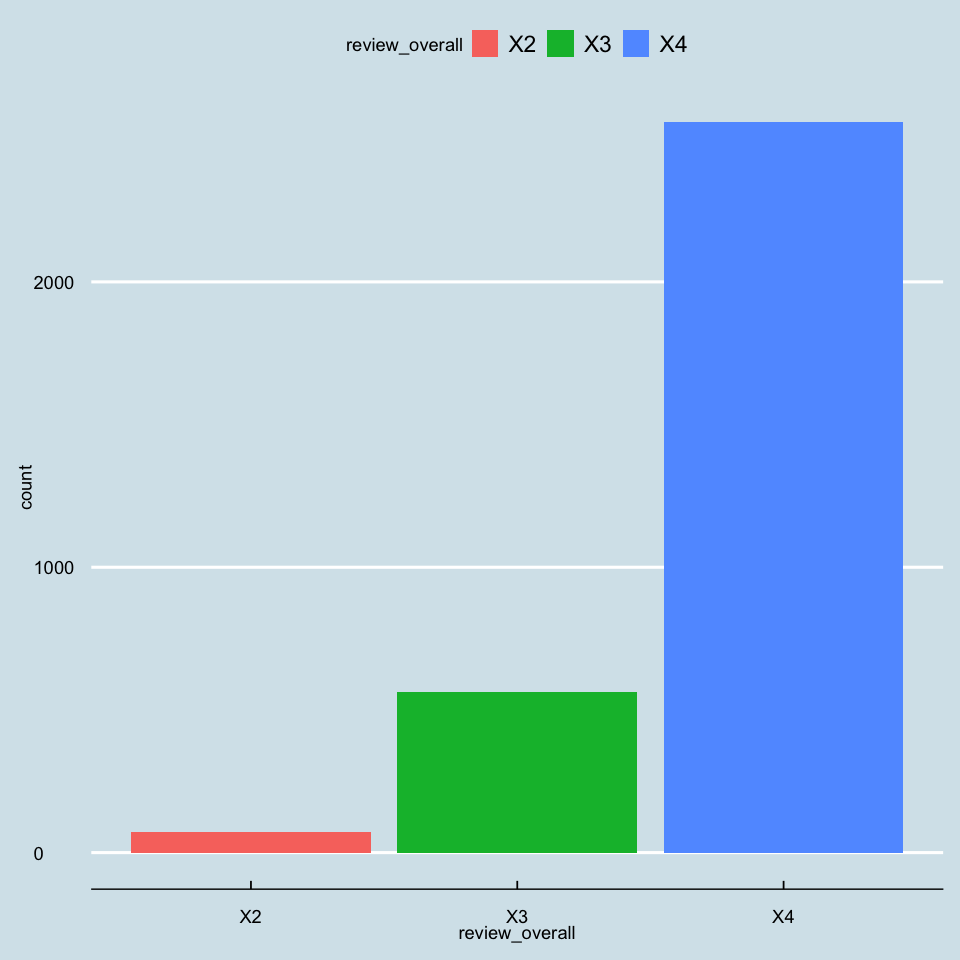

In [16]:
data_for_prediction <- data %>% mutate(review_overall = round(review_overall))
data_for_prediction$review_overall <- ifelse (data_for_prediction$review_overall == 1, 2, data_for_prediction$review_overall)
data_for_prediction$review_overall <- ifelse (data_for_prediction$review_overall == 5, 4, data_for_prediction$review_overall)
data_for_prediction <- data_for_prediction %>% mutate(review_overall = as.factor(make.names(review_overall))) %>% dplyr::select(ABV:Malty, review_overall)

options(repr.plot.width=8, repr.plot.height=8)

data_for_prediction %>% ggplot(aes(review_overall, fill = review_overall)) + geom_bar() + theme_economist()

In [17]:
data_for_prediction %>% summarize(bad = sum(review_overall == 'X2'), medium = sum(review_overall == 'X3'), good = sum(review_overall == 'X4'))
str(data_for_prediction)

bad medium good
1 73  563    2561

tibble [3,197 × 15] (S3: tbl_df/tbl/data.frame)
 $ ABV           : num [1:3197] 5.3 7.2 5 8.5 7.2 6 5.3 5 4.8 5.1 ...
 $ Min.IBU       : num [1:3197] 25 25 25 25 25 25 25 25 25 25 ...
 $ Max.IBU       : num [1:3197] 50 50 50 50 50 50 50 50 50 50 ...
 $ Astringency   : num [1:3197] 13 12 14 13 25 22 28 18 25 35 ...
 $ Body          : num [1:3197] 32 57 37 55 51 45 40 49 35 31 ...
 $ Alcohol       : num [1:3197] 9 18 6 31 26 13 3 5 4 5 ...
 $ Bitter        : num [1:3197] 47 33 42 47 44 46 40 37 38 35 ...
 $ Sweet         : num [1:3197] 74 55 43 101 45 62 58 73 39 50 ...
 $ Sour          : num [1:3197] 33 16 11 18 9 25 29 22 13 55 ...
 $ Salty         : num [1:3197] 0 0 0 1 1 1 0 0 1 5 ...
 $ Fruits        : num [1:3197] 33 24 10 49 11 34 36 21 8 52 ...
 $ Hoppy         : num [1:3197] 57 35 54 40 51 60 54 37 60 66 ...
 $ Spices        : num [1:3197] 8 12 4 16 20 4 8 4 16 8 ...
 $ Malty         : num [1:3197] 111 84 62 119 95 103 97 98 97 77 ...
 $ review_overall: Factor w/ 3 levels "X2","

Most of the data are good quality beers. We can see huge disproportion between classes.<br>
The data nearly do not contain bad quality beers - as we can see there are only 73 beers in class marked as X2, among 3197 beers at all.

## Analyse of the beers atributes

In [18]:
# Creating subset of data for analying atributes
data_atributes <- data %>% dplyr::select(Name, Style, ABV:Malty, )
# Function for scaling/standarizing values for features related to tasting profile
normalize <- function(x) {
                return (x-mean(x))/sd(x)
}
# Scaling
data_atributes[, -c(1:5)] <- apply(data_atributes[,-c(1:5)], 2, normalize)
data_atributes[, -c(1:5)] <- t(apply(t(data_atributes[,-c(1:5)]), 2, normalize))
data_for_prediction[, -c(1:3, ncol(data_for_prediction))] <- apply(data_for_prediction[,-c(1:3,ncol(data_for_prediction))],2, normalize)
data_for_prediction[, -c(1:3, ncol(data_for_prediction))] <- t(apply(t(data_for_prediction[,-c(1:3,ncol(data_for_prediction))]),2, normalize))

In [19]:
# Getting basic statistics of atributes columns
data_atributes %>% dplyr::select(ABV:Malty) %>% summary()

      ABV          Min.IBU        Max.IBU     Astringency         Body      
 Min.   : 0.0   Min.   : 0.0   Min.   :  0   Min.   :-46.4   Min.   :-46.4  
 1st Qu.: 5.0   1st Qu.:15.0   1st Qu.: 25   1st Qu.: -9.8   1st Qu.:-12.4  
 Median : 6.0   Median :20.0   Median : 35   Median : -0.4   Median : -5.9  
 Mean   : 6.5   Mean   :21.2   Mean   : 39   Mean   :  0.0   Mean   :  0.0  
 3rd Qu.: 7.6   3rd Qu.:25.0   3rd Qu.: 45   3rd Qu.: 10.3   3rd Qu.:  6.4  
 Max.   :57.5   Max.   :65.0   Max.   :100   Max.   : 49.2   Max.   : 97.5  
    Alcohol          Bitter          Sweet            Sour      
 Min.   :-41.6   Min.   :-59.9   Min.   :-51.7   Min.   :-57.5  
 1st Qu.:-10.5   1st Qu.:-14.2   1st Qu.:-19.7   1st Qu.:-17.7  
 Median : -3.0   Median : -1.4   Median : -5.6   Median : -6.9  
 Mean   :  0.0   Mean   :  0.0   Mean   :  0.0   Mean   :  0.0  
 3rd Qu.:  7.8   3rd Qu.: 12.6   3rd Qu.: 13.7   3rd Qu.:  6.2  
 Max.   :118.4   Max.   : 85.2   Max.   :165.7   Max.   :221.3  
     S

In [20]:
sum(data_atributes$ABV == 0) # Number of non-alcoholic beers

[1] 12

In [21]:
sum(data_atributes$ABV > 15) # Number of extremely strong beers

[1] 14

In [22]:
data_atributes[which.max(data_atributes$ABV),]

Name             Style          ABV  Min.IBU Max.IBU Astringency Body 
1 Schorschbock 57% Bock - Eisbock 57.5 25      35      12.9        -9.71
  Alcohol Bitter Sweet Sour Salty Fruits Hoppy Spices Malty
1 29.4    -3.94  -19.8 2.28 28.4  0.891  -11.5 13.1   -41.9

As we can see, there are 12 non-alcoholic beers in our original dataset. Also there are some beers with unusual alcohol content (over 15%) with Schorschbock at the fore (with spectacular 57.5 % of alcohol).
<br>Most of the beers don't exceed 8% of alcohol and what is not surprising the average percentage of alcohol in beers is 6.5%. Mean value and median are nearly the same because beyond typical beers there are both non-alcoholic/low-percentage and stout beers.

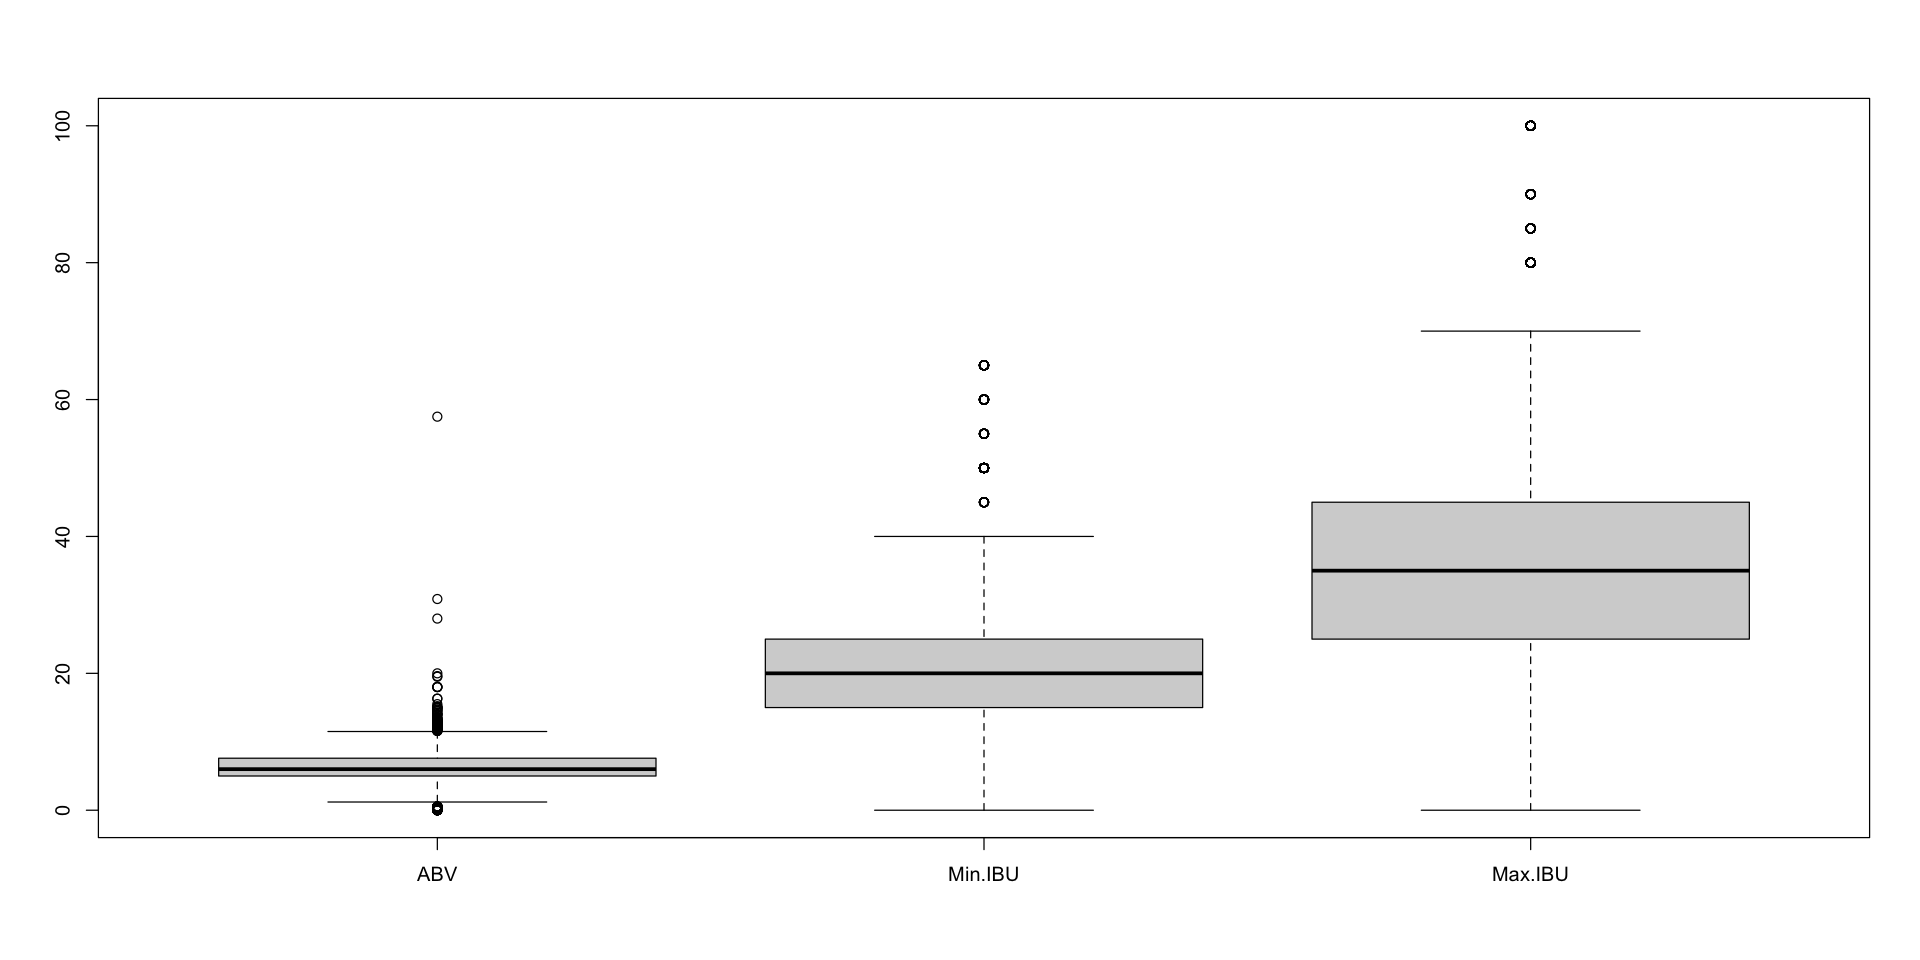

In [23]:
par(bg = 'white')
options(repr.plot.width=16, repr.plot.height=8)
data_atributes %>% dplyr::select(ABV:Max.IBU) %>% boxplot()

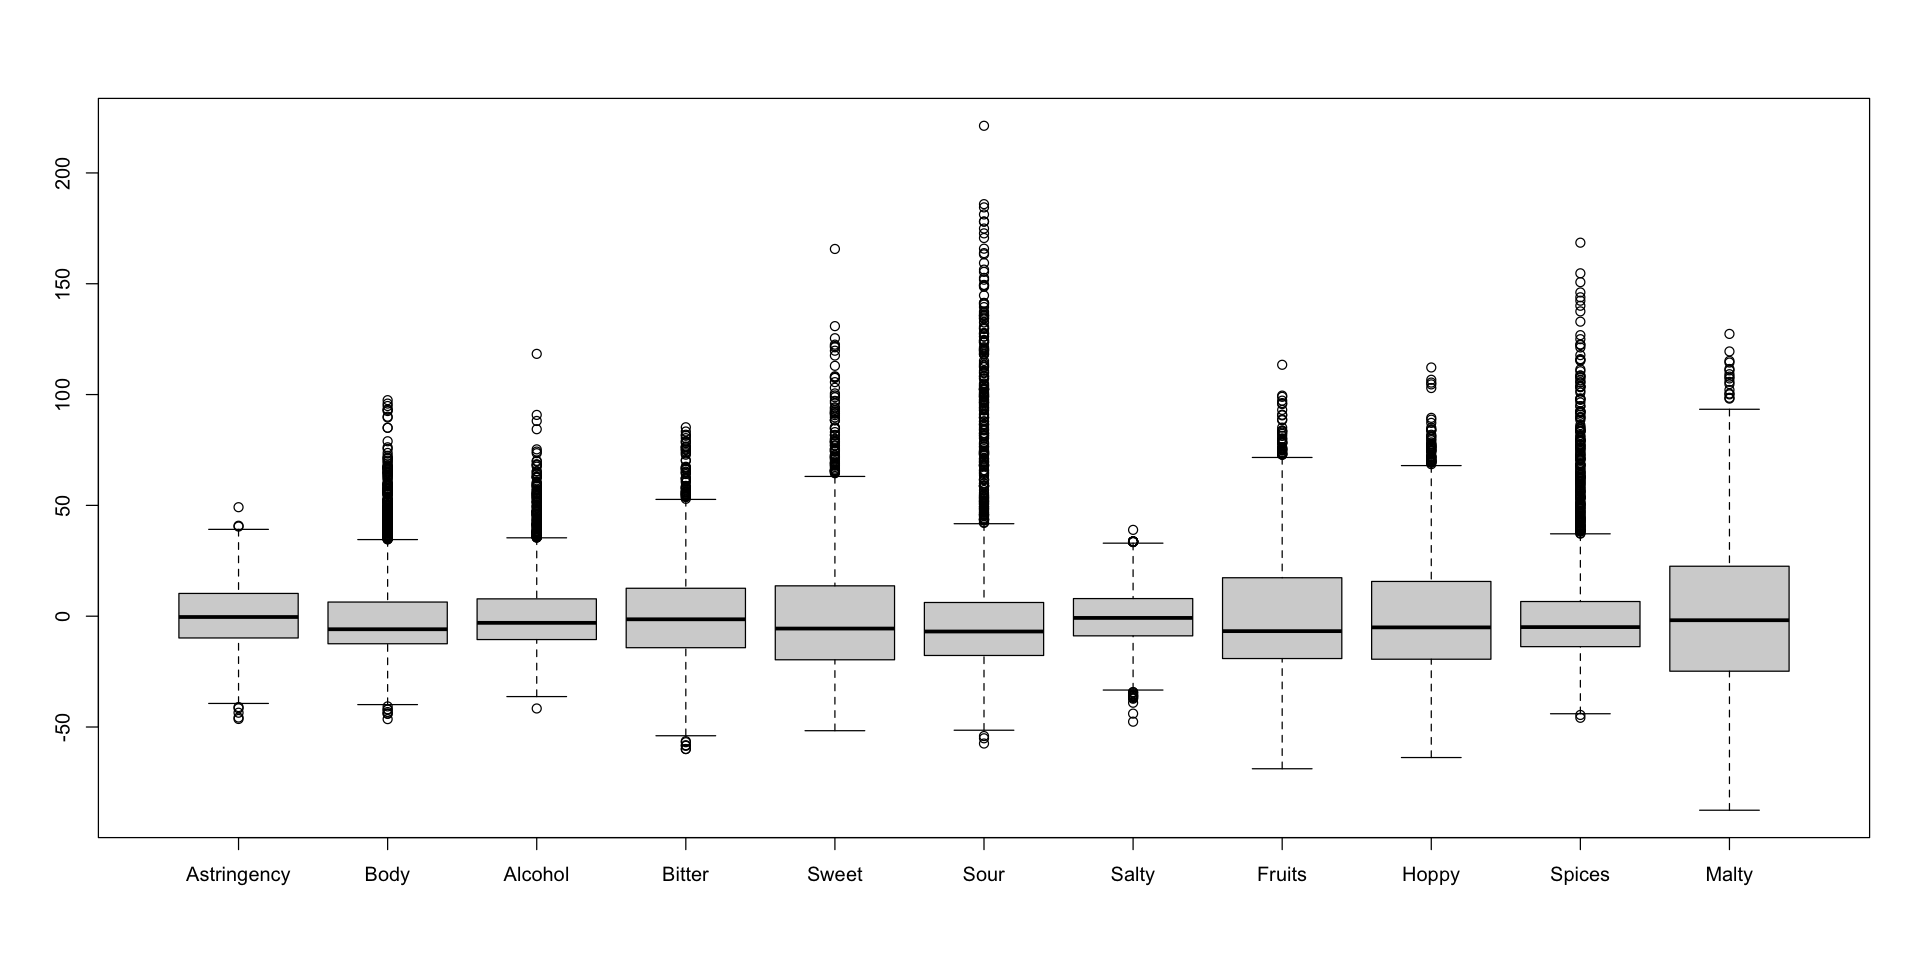

In [24]:
par(bg = 'white')
options(repr.plot.width=16, repr.plot.height=8)
data_atributes %>% dplyr::select(Astringency:Malty) %>% boxplot()

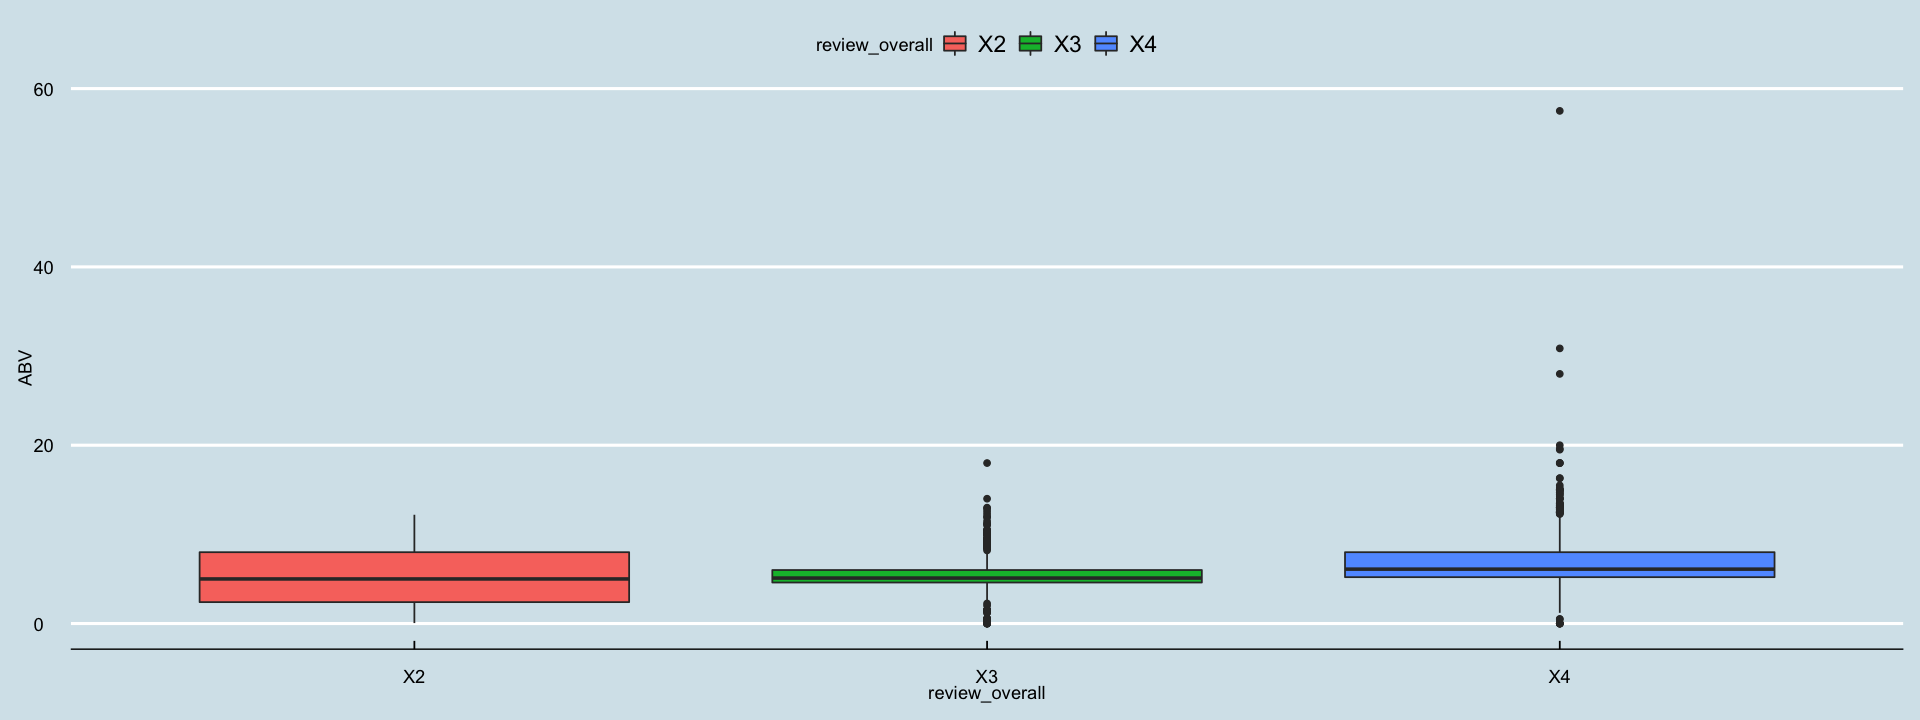

In [25]:
options(repr.plot.width=16, repr.plot.height=6)
data_for_prediction %>% ggplot(aes(review_overall, ABV, fill = review_overall)) + geom_boxplot() + theme_economist()

The alcohol content does not seems to have big impact on the beer's review. Good beers have a little bit higher median than others. There is also bigger variability in ABV for bad quality beers.

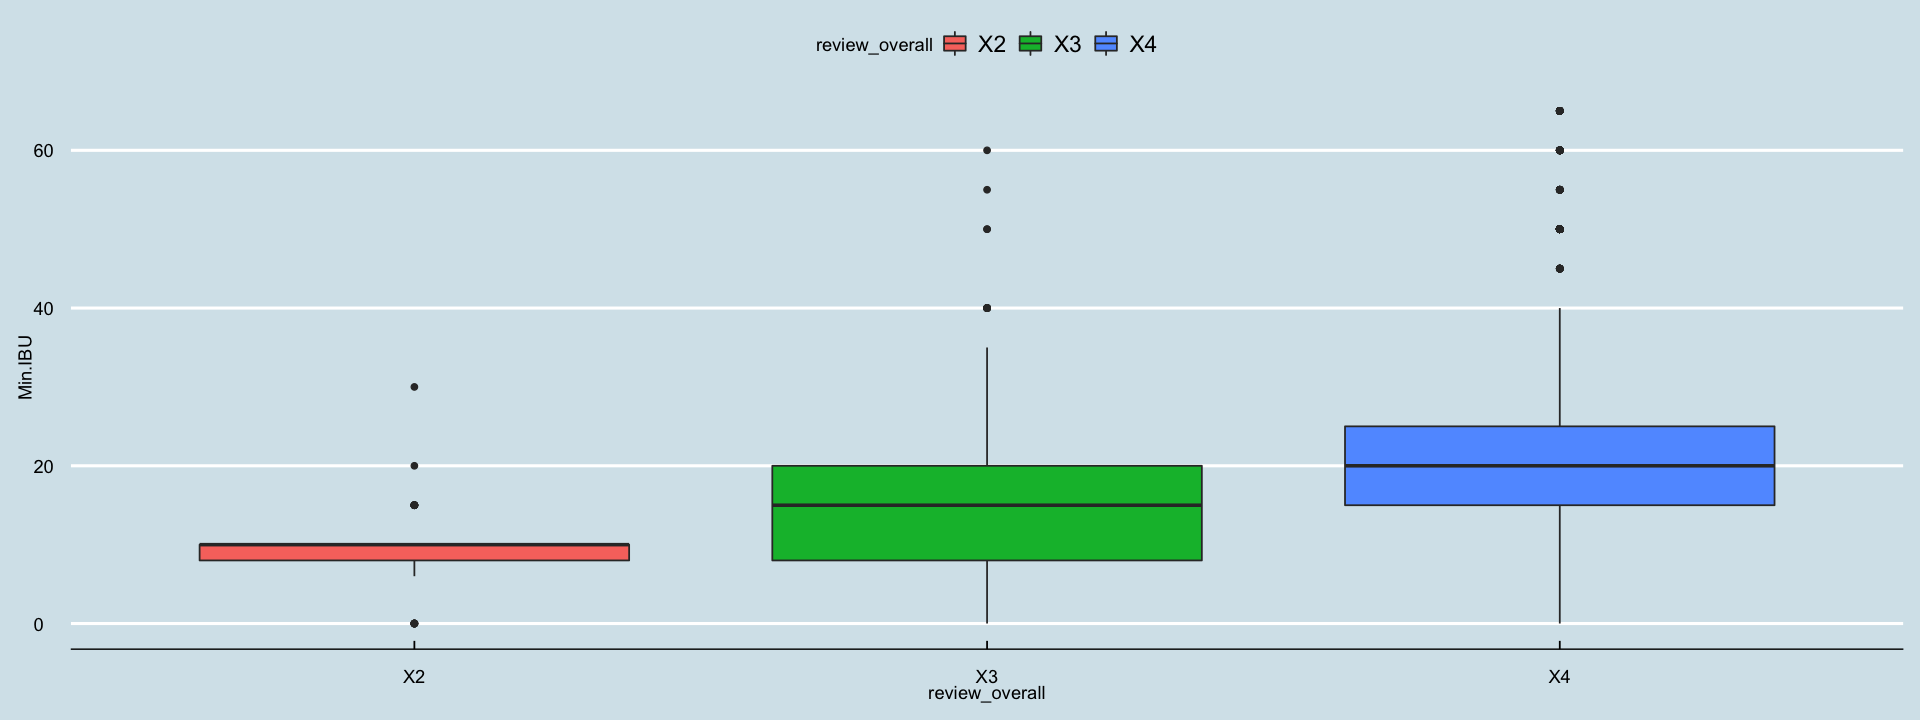

In [26]:
data_for_prediction %>% ggplot(aes(review_overall, Min.IBU, fill = review_overall)) + geom_boxplot() + theme_economist()

By looking at the above boxplot comparison we can say that better reviewed beers have higher value of minimum bitterness units.

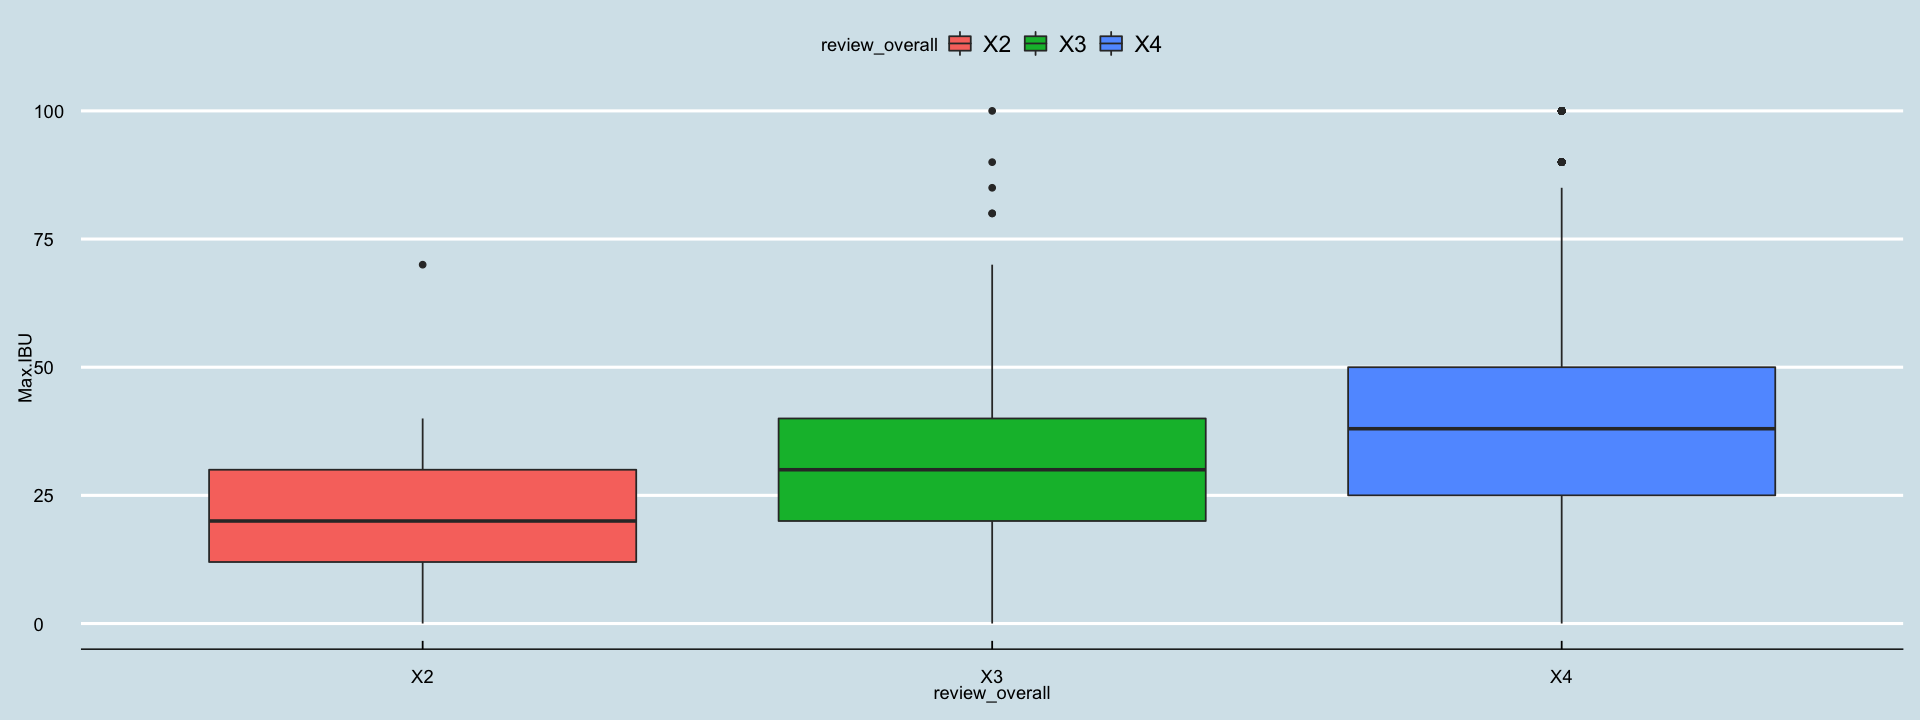

In [27]:
data_for_prediction %>% ggplot(aes(review_overall, Max.IBU, fill = review_overall)) + geom_boxplot() + theme_economist()

Beers with higher overall have also higher values of Max IBU. We can assume that Min IBU and Max IBU are highly corelated because they are not independent - they create a range of values.

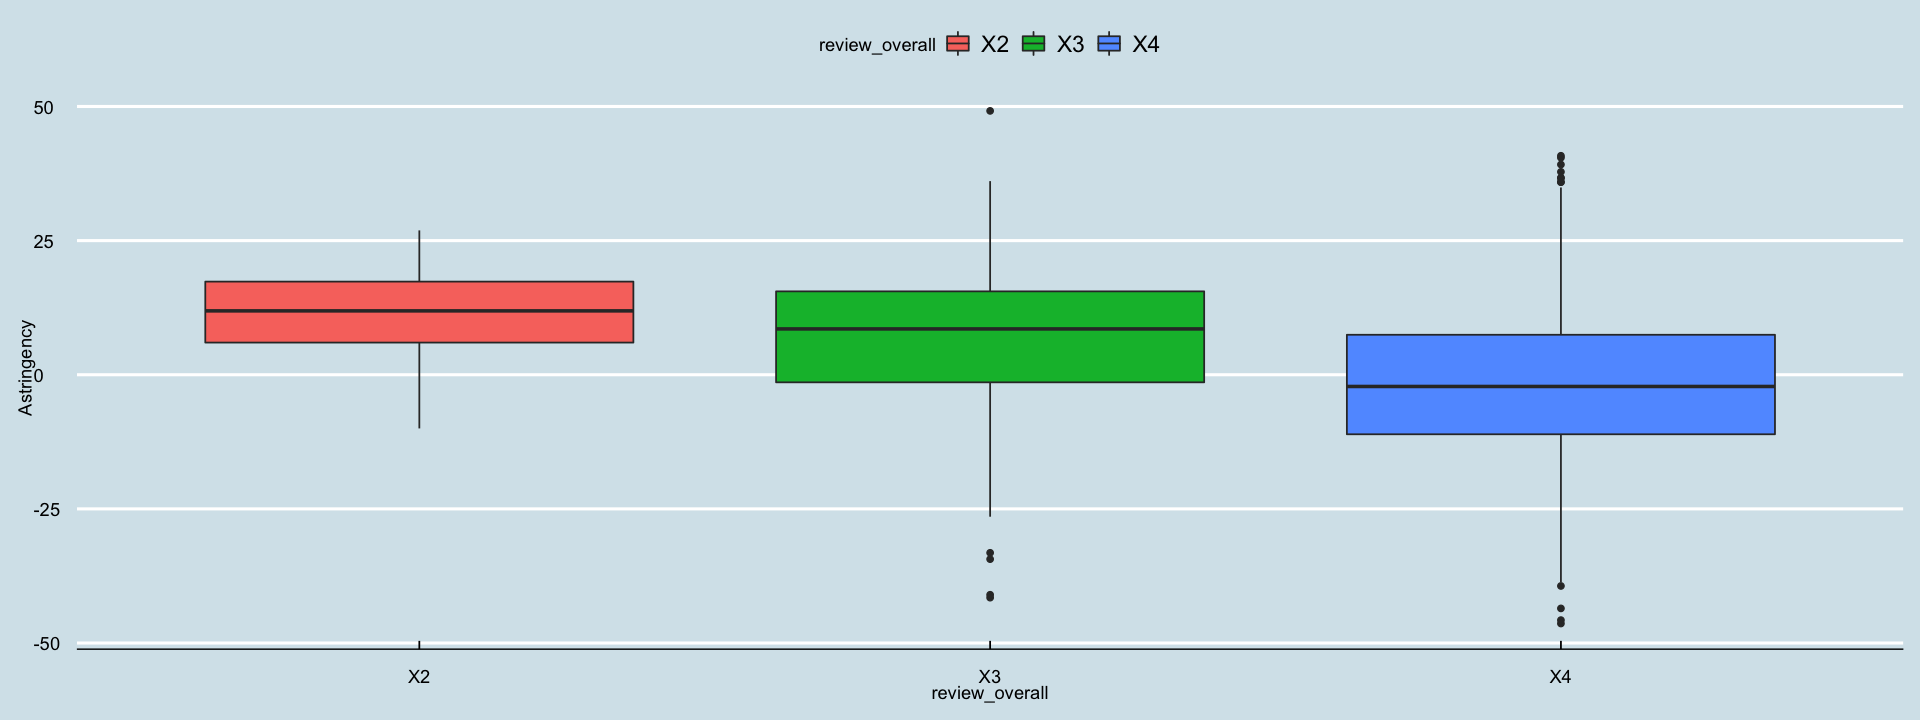

In [28]:
data_for_prediction %>% ggplot(aes(review_overall, Astringency, fill = review_overall)) + geom_boxplot() + theme_economist()

Comparing boxplots for each grade we see that beers described as more astrigent are worse for consumers.

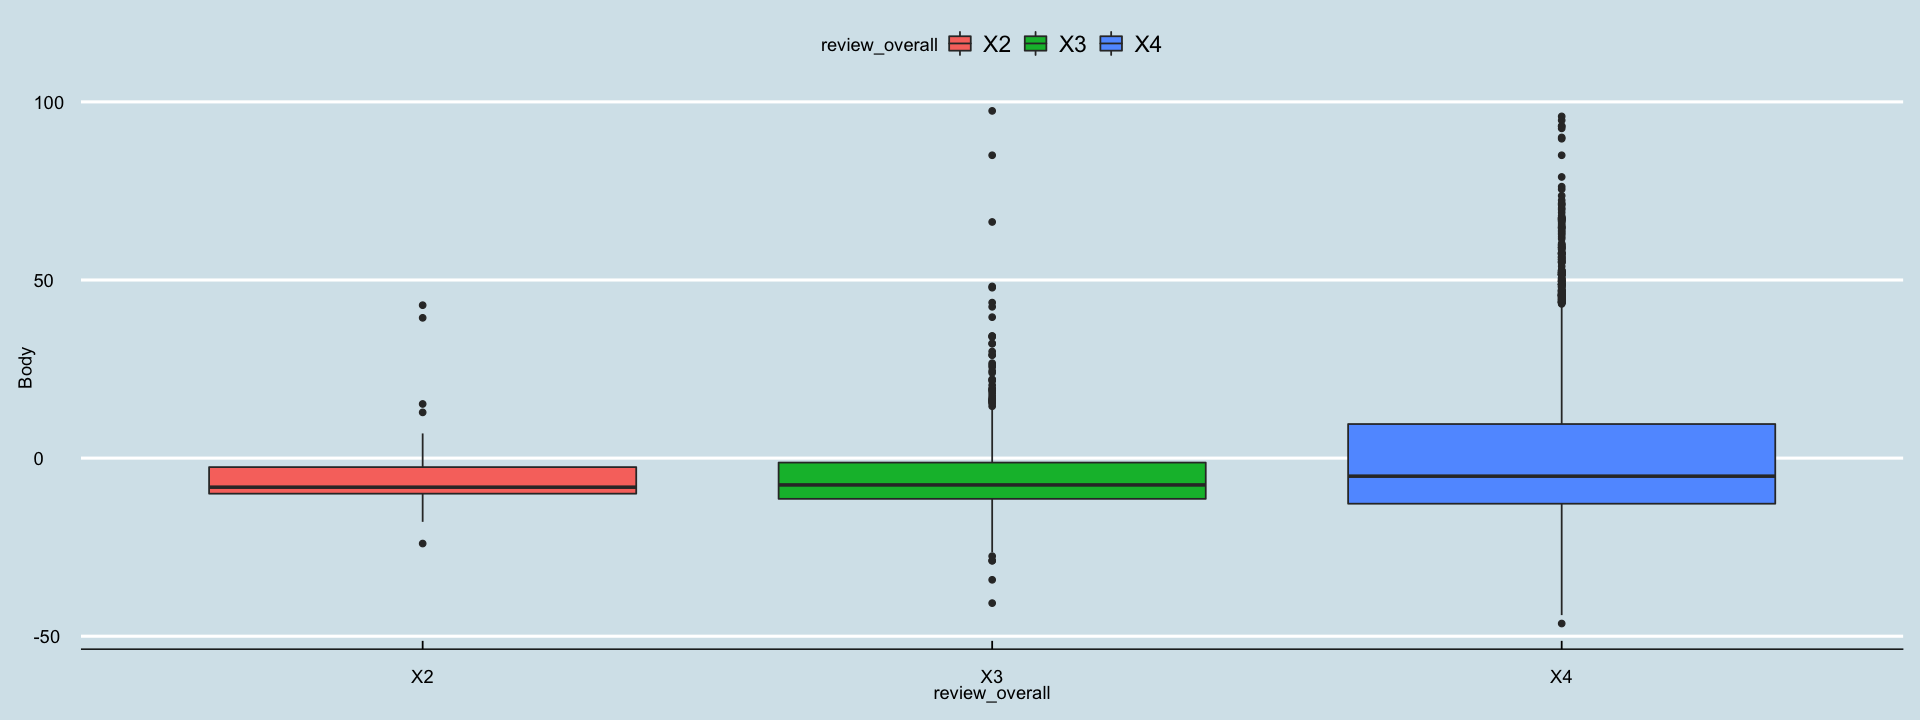

In [29]:
data_for_prediction %>% ggplot(aes(review_overall, Body, fill = review_overall)) + geom_boxplot() + theme_economist()

Higher body indicator makes beer a little bit better. Also for beers reviewed as good, there is bigger variability in the value of body indicator.

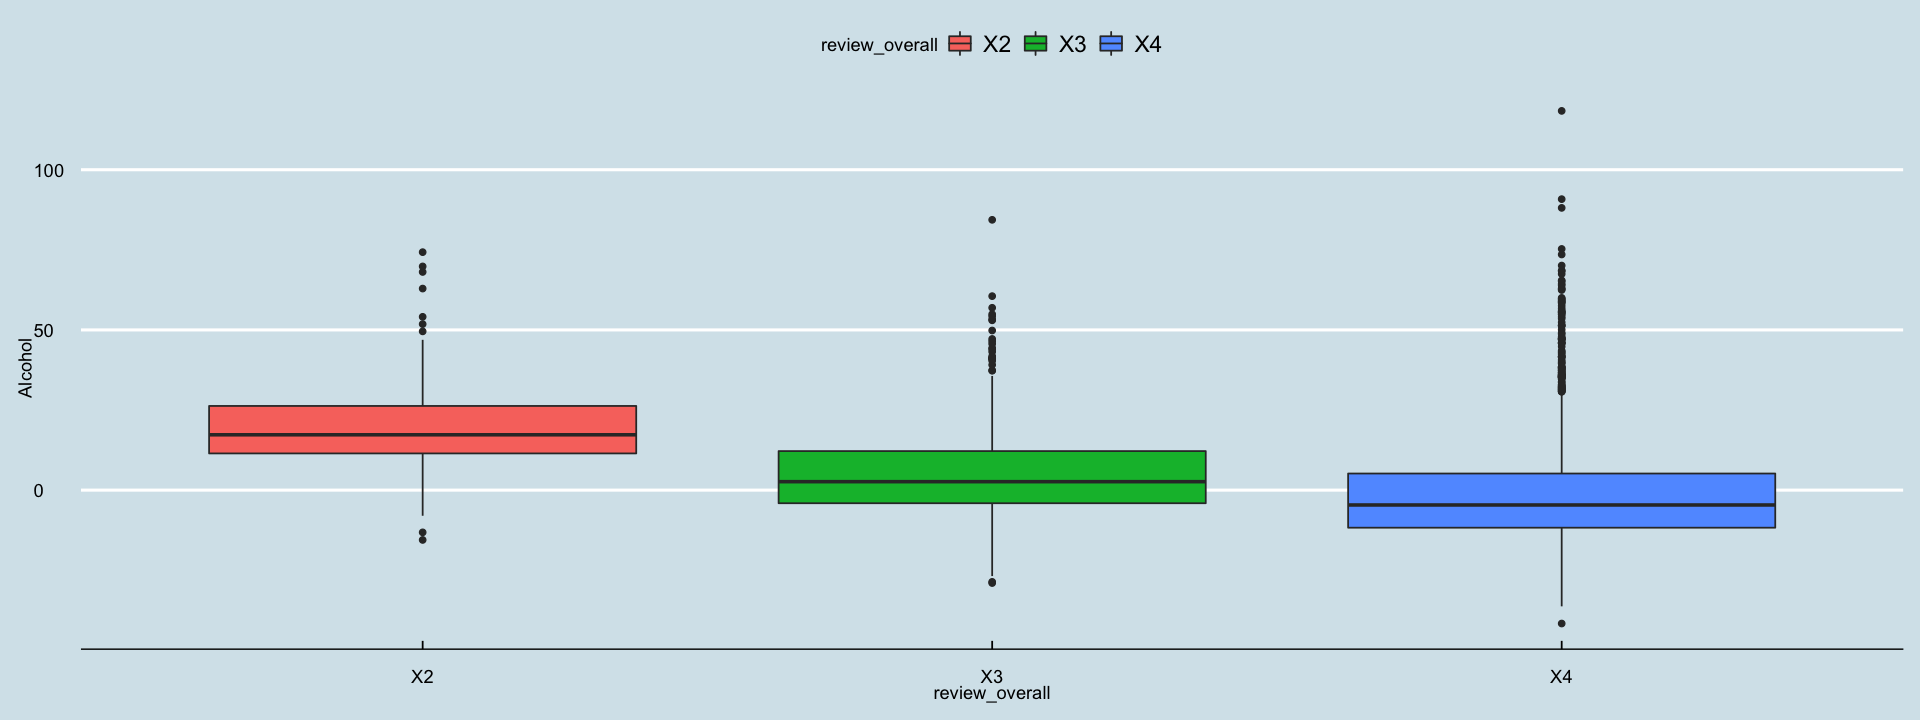

In [30]:
data_for_prediction %>% ggplot(aes(review_overall, Alcohol, fill = review_overall)) + geom_boxplot() + theme_economist()

Typically beers where alcohol taste is more noticeable are rated lower. On the other hand there are many outliners for medium and good beers with high value of 'Alcohol' indicator. So when beer is more alcoholic in taste it does not always mean that it is bad quality one, but it is highly probable. 

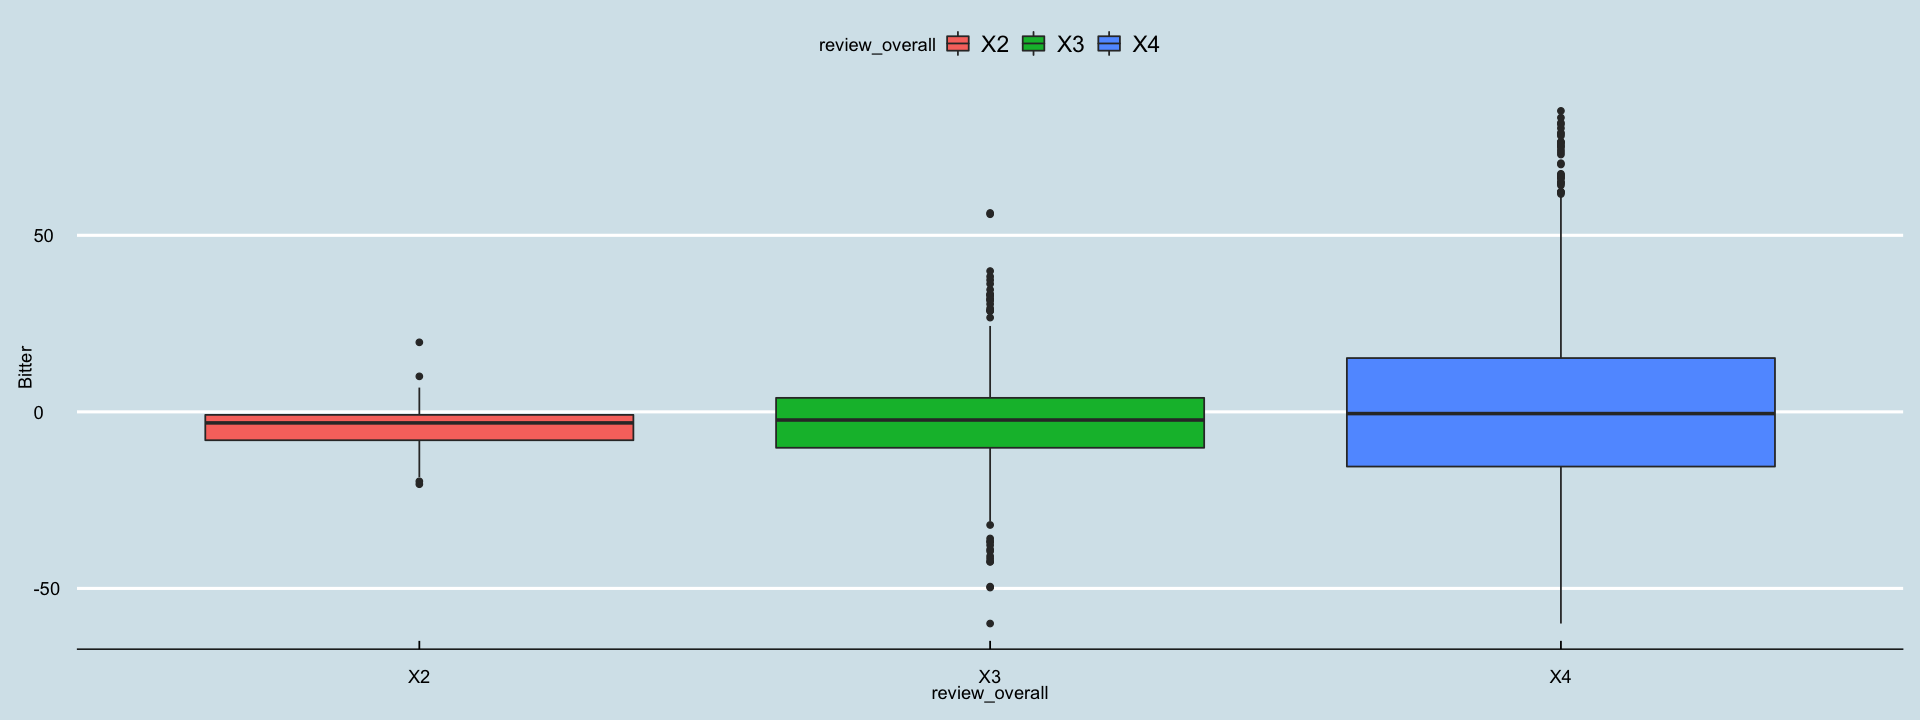

In [31]:
data_for_prediction %>% ggplot(aes(review_overall, Bitter, fill = review_overall)) + geom_boxplot() + theme_economist()

Beers described as bitter are reviewed higher, but the difference in the value of 'Bitter" indicator between low and high rated beers is really small.

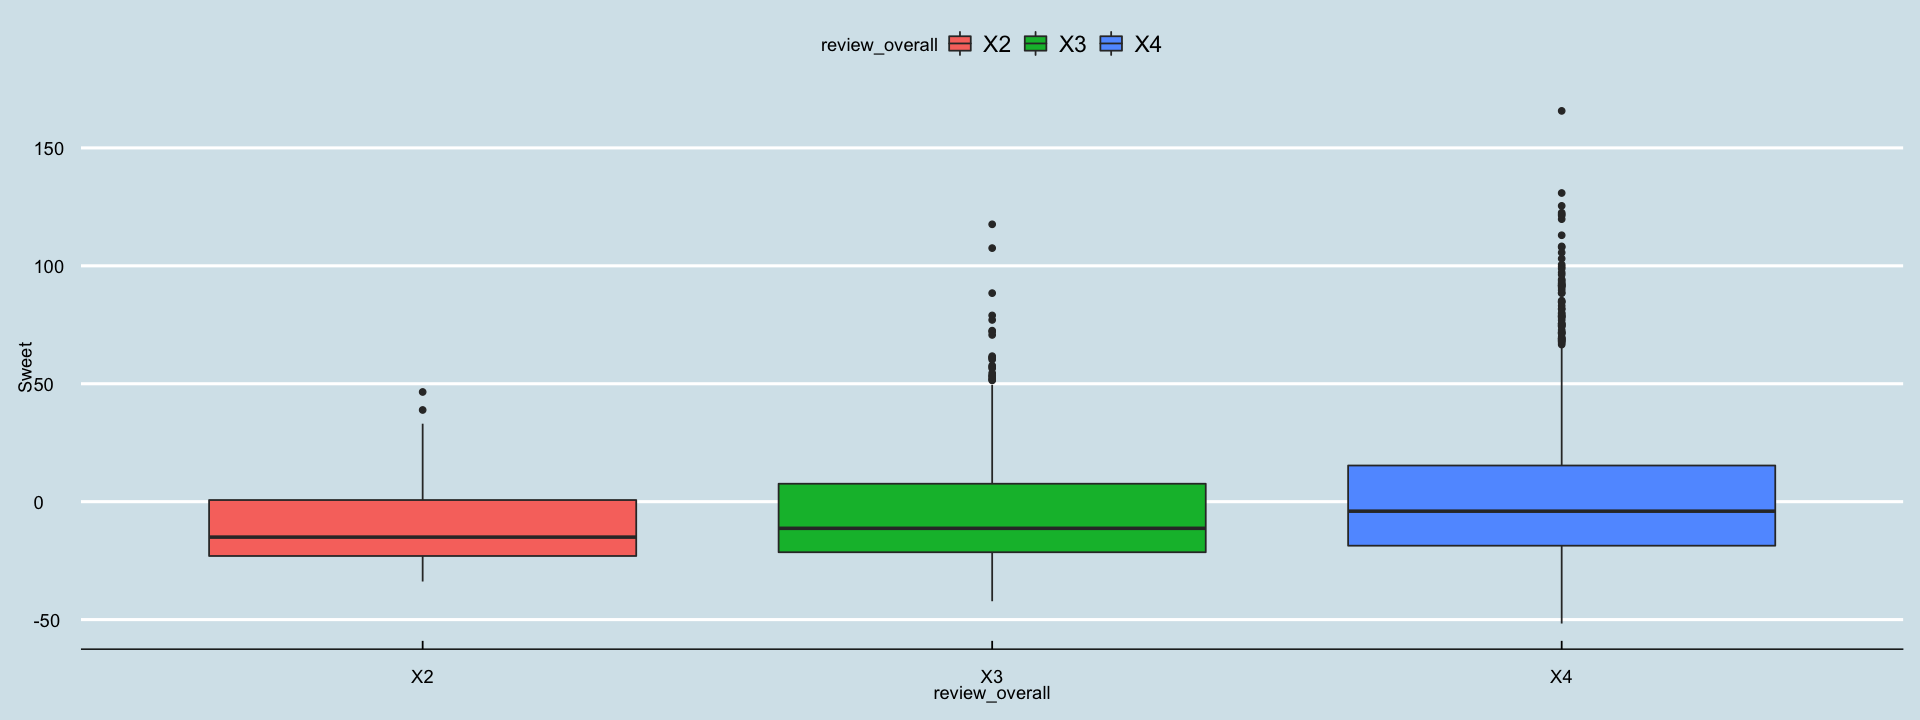

In [32]:
data_for_prediction %>% ggplot(aes(review_overall, Sweet, fill = review_overall)) + geom_boxplot() + theme_economist()

Sweetness of a beer makes it rated higher.

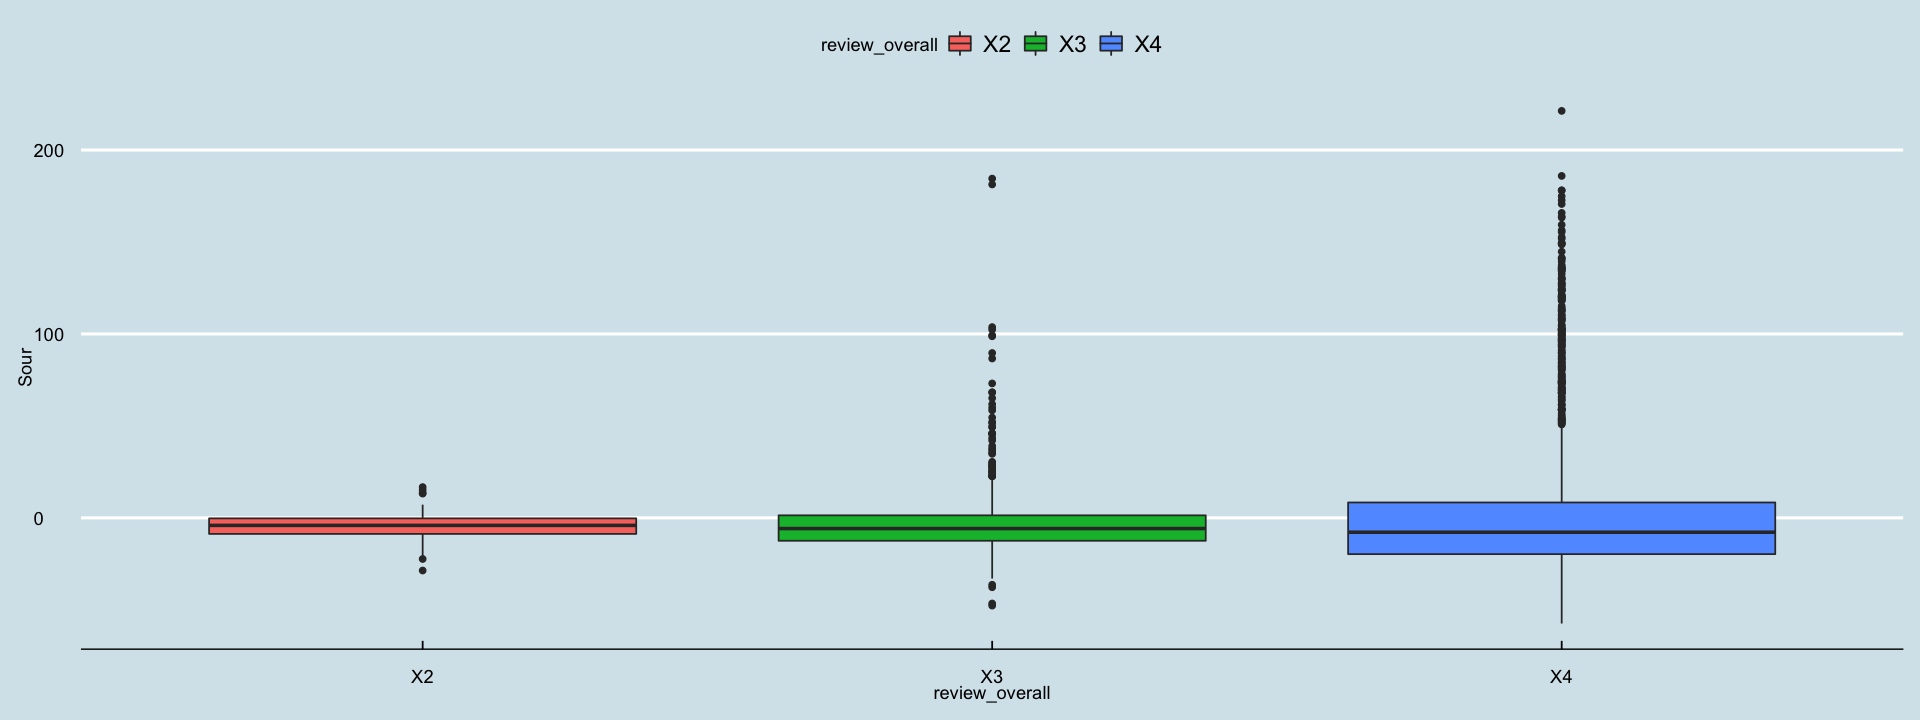

In [33]:
data_for_prediction %>% ggplot(aes(review_overall, Sour, fill = review_overall)) + geom_boxplot() + theme_economist()

Sourness does not seem to have impact on the review.

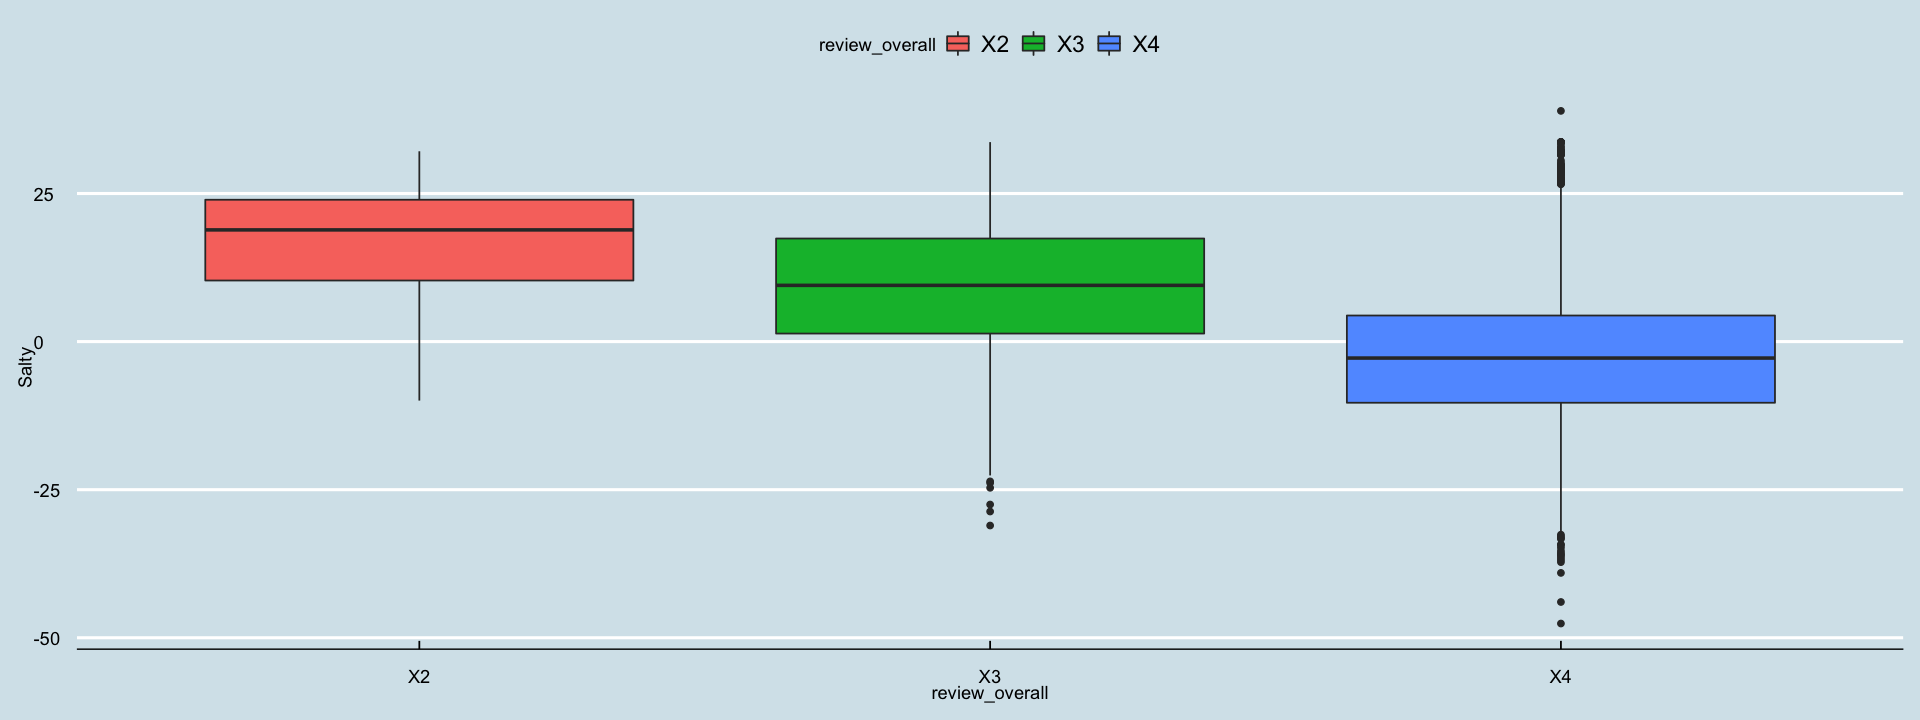

In [34]:
data_for_prediction %>% ggplot(aes(review_overall, Salty, fill = review_overall)) + geom_boxplot() + theme_economist()

Saltiness of the beer is the reason why consumers rate it low.

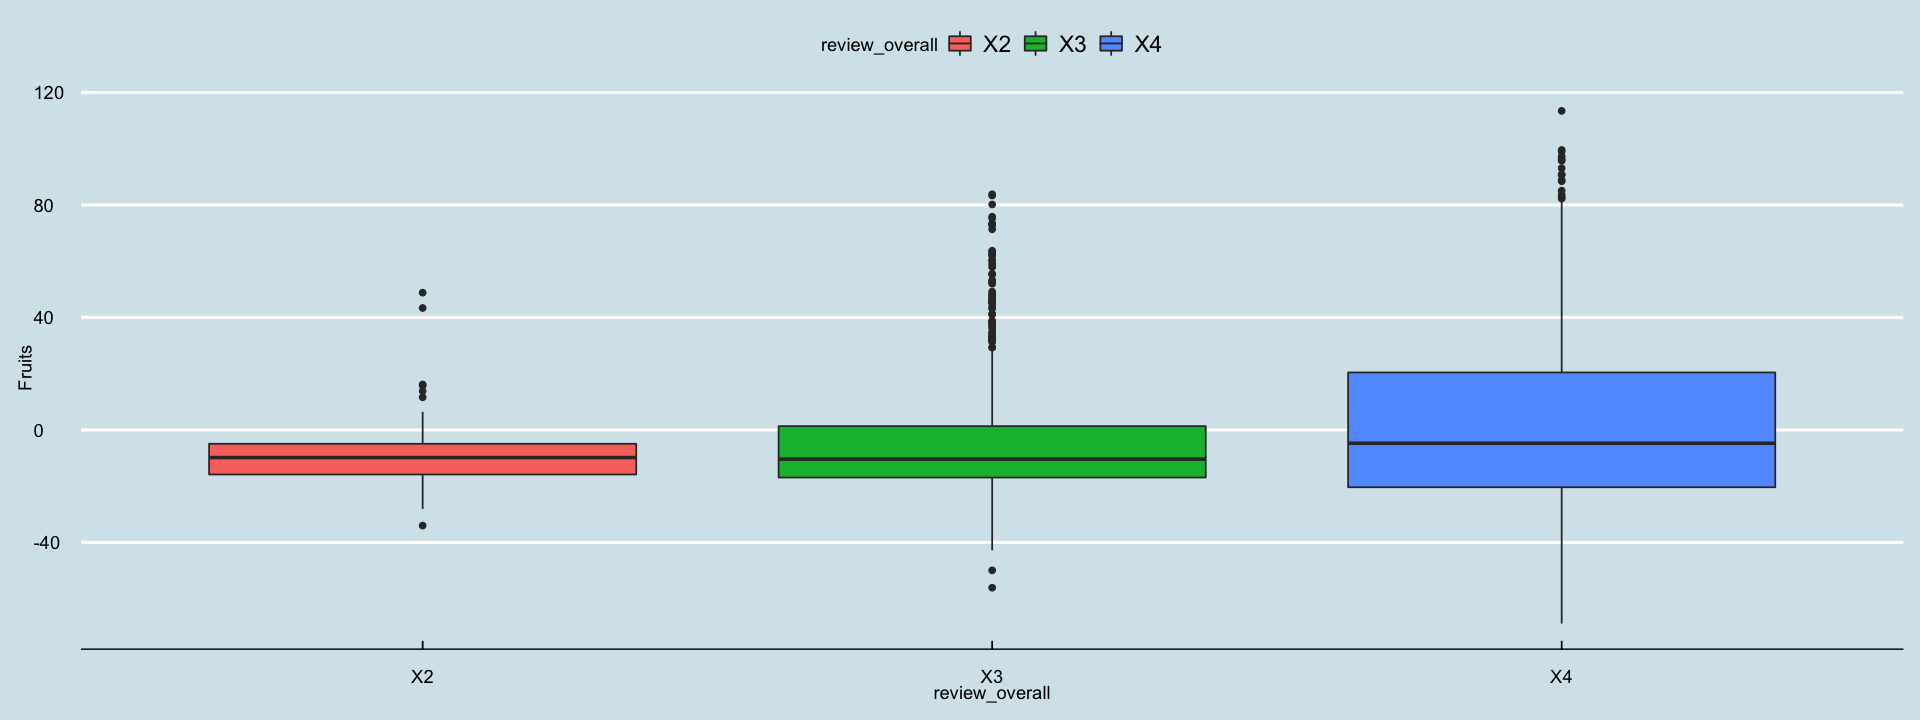

In [35]:
data_for_prediction %>% ggplot(aes(review_overall, Fruits, fill = review_overall)) + geom_boxplot() + theme_economist()

Beers descripted with fruit flavors are generally reviewed better.

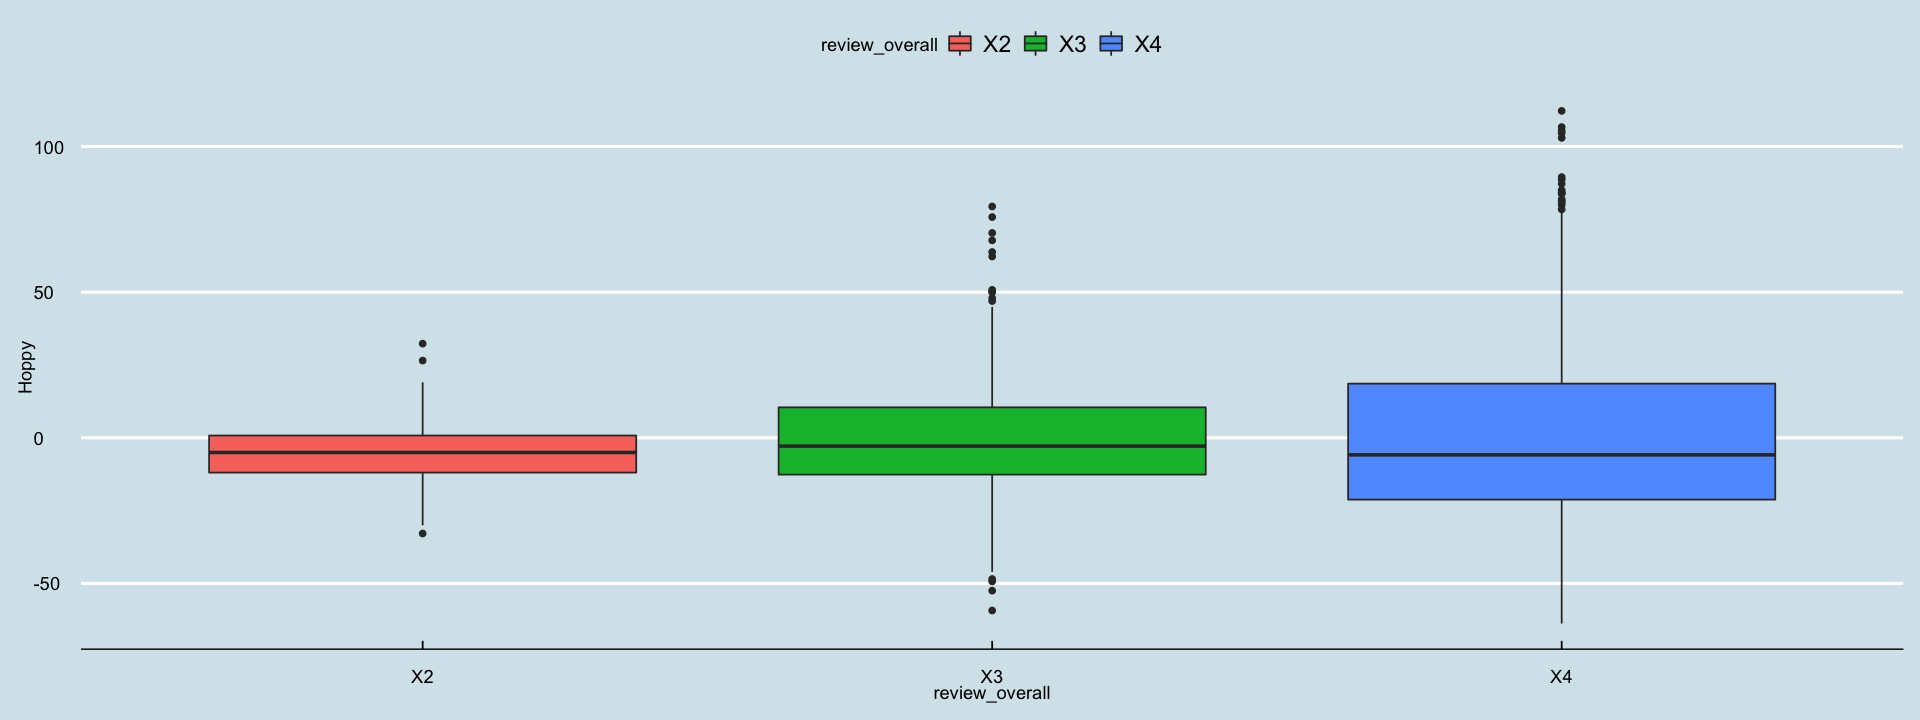

In [36]:
data_for_prediction %>% ggplot(aes(review_overall, Hoppy, fill = review_overall)) + geom_boxplot() + theme_economist()

Describing beer with words connected with being hoppy does not seem to have impact on review.

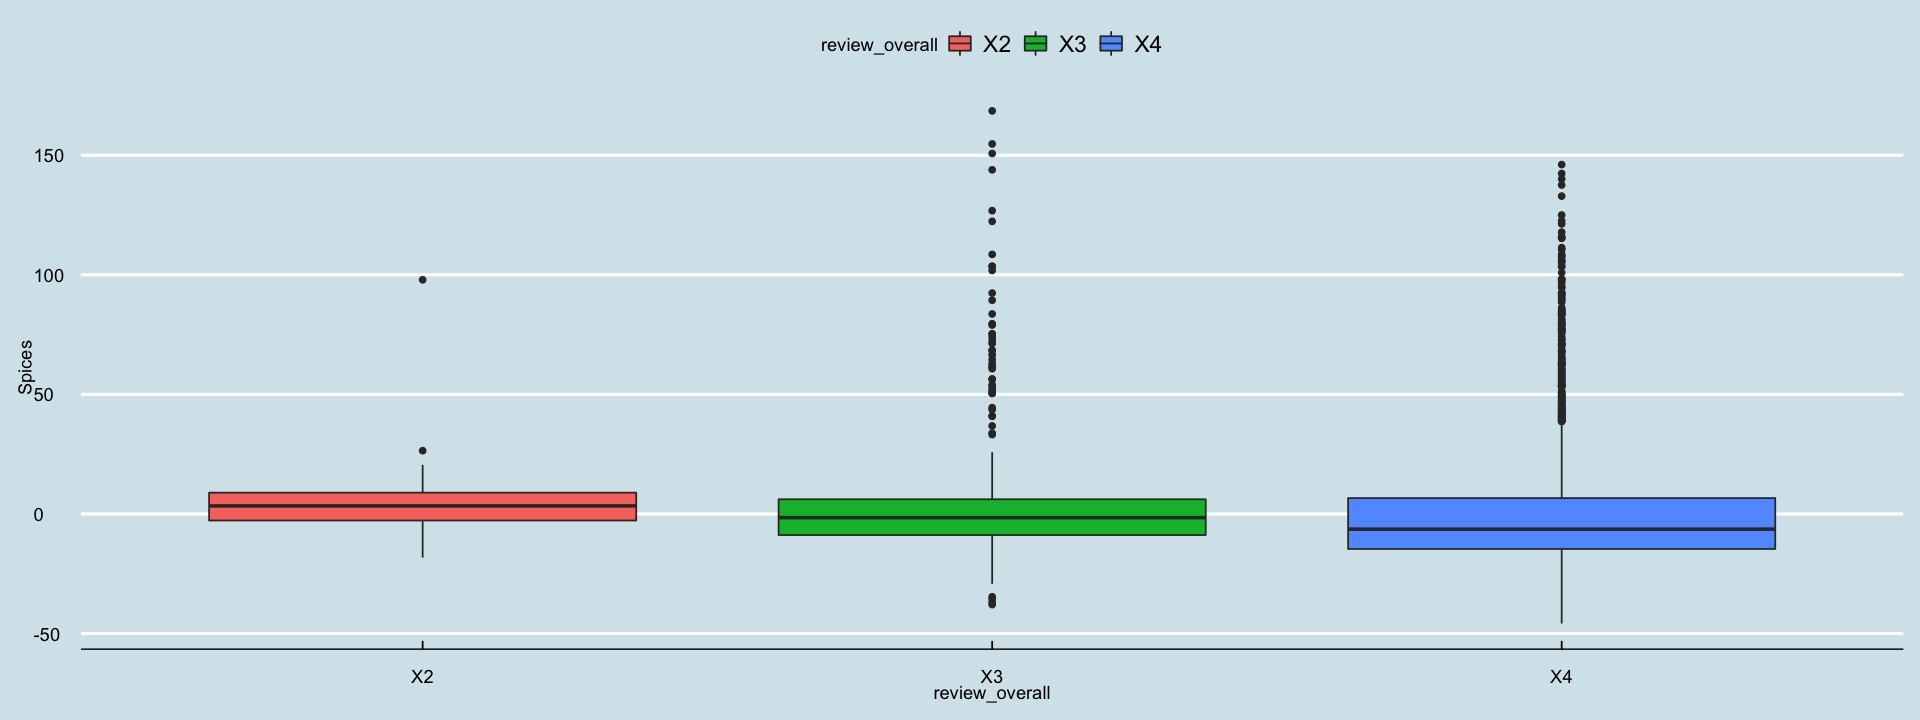

In [37]:
data_for_prediction %>% ggplot(aes(review_overall, Spices, fill = review_overall)) + geom_boxplot() + theme_economist()

Beers with noticable spices are reviewed worse (ommiting outliers).

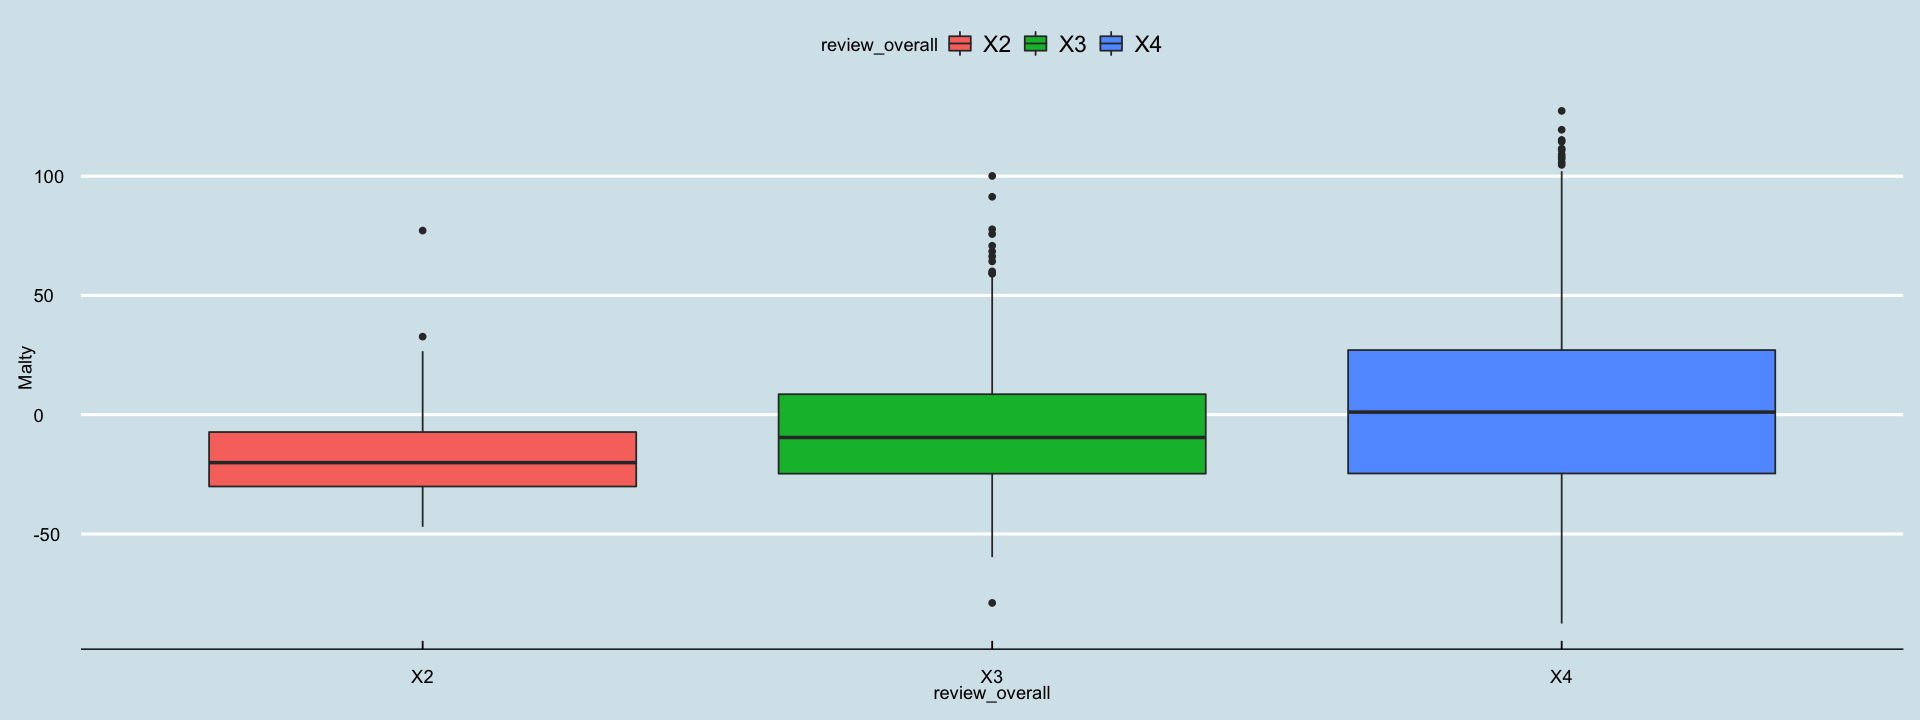

In [38]:
data_for_prediction %>% ggplot(aes(review_overall, Malty, fill = review_overall)) + geom_boxplot() + theme_economist()

Malty beers are generally reviewed better.

### Conclusion
- There are some atributes that do not have impact on beers quality, for example 'Hoppy' or 'Sour'.
- Some of the atributes negatively affect the reviews. Among these atributes are for example 'Alcohol', 'Salty' and 'Astringency'.
- Also there are atributes with possitive impact on quality, for example 'Malty', 'Min.IBU' and 'Max.IBU'.
- For every atribute there are many outliers for good beers and medium beers, but there are also much more observations than for bad quality beers.
- Min.IBU and Max.IBU are not independent, so they are probably also high correlated. It is possible that one of these arguments will be removed for the prediction task.




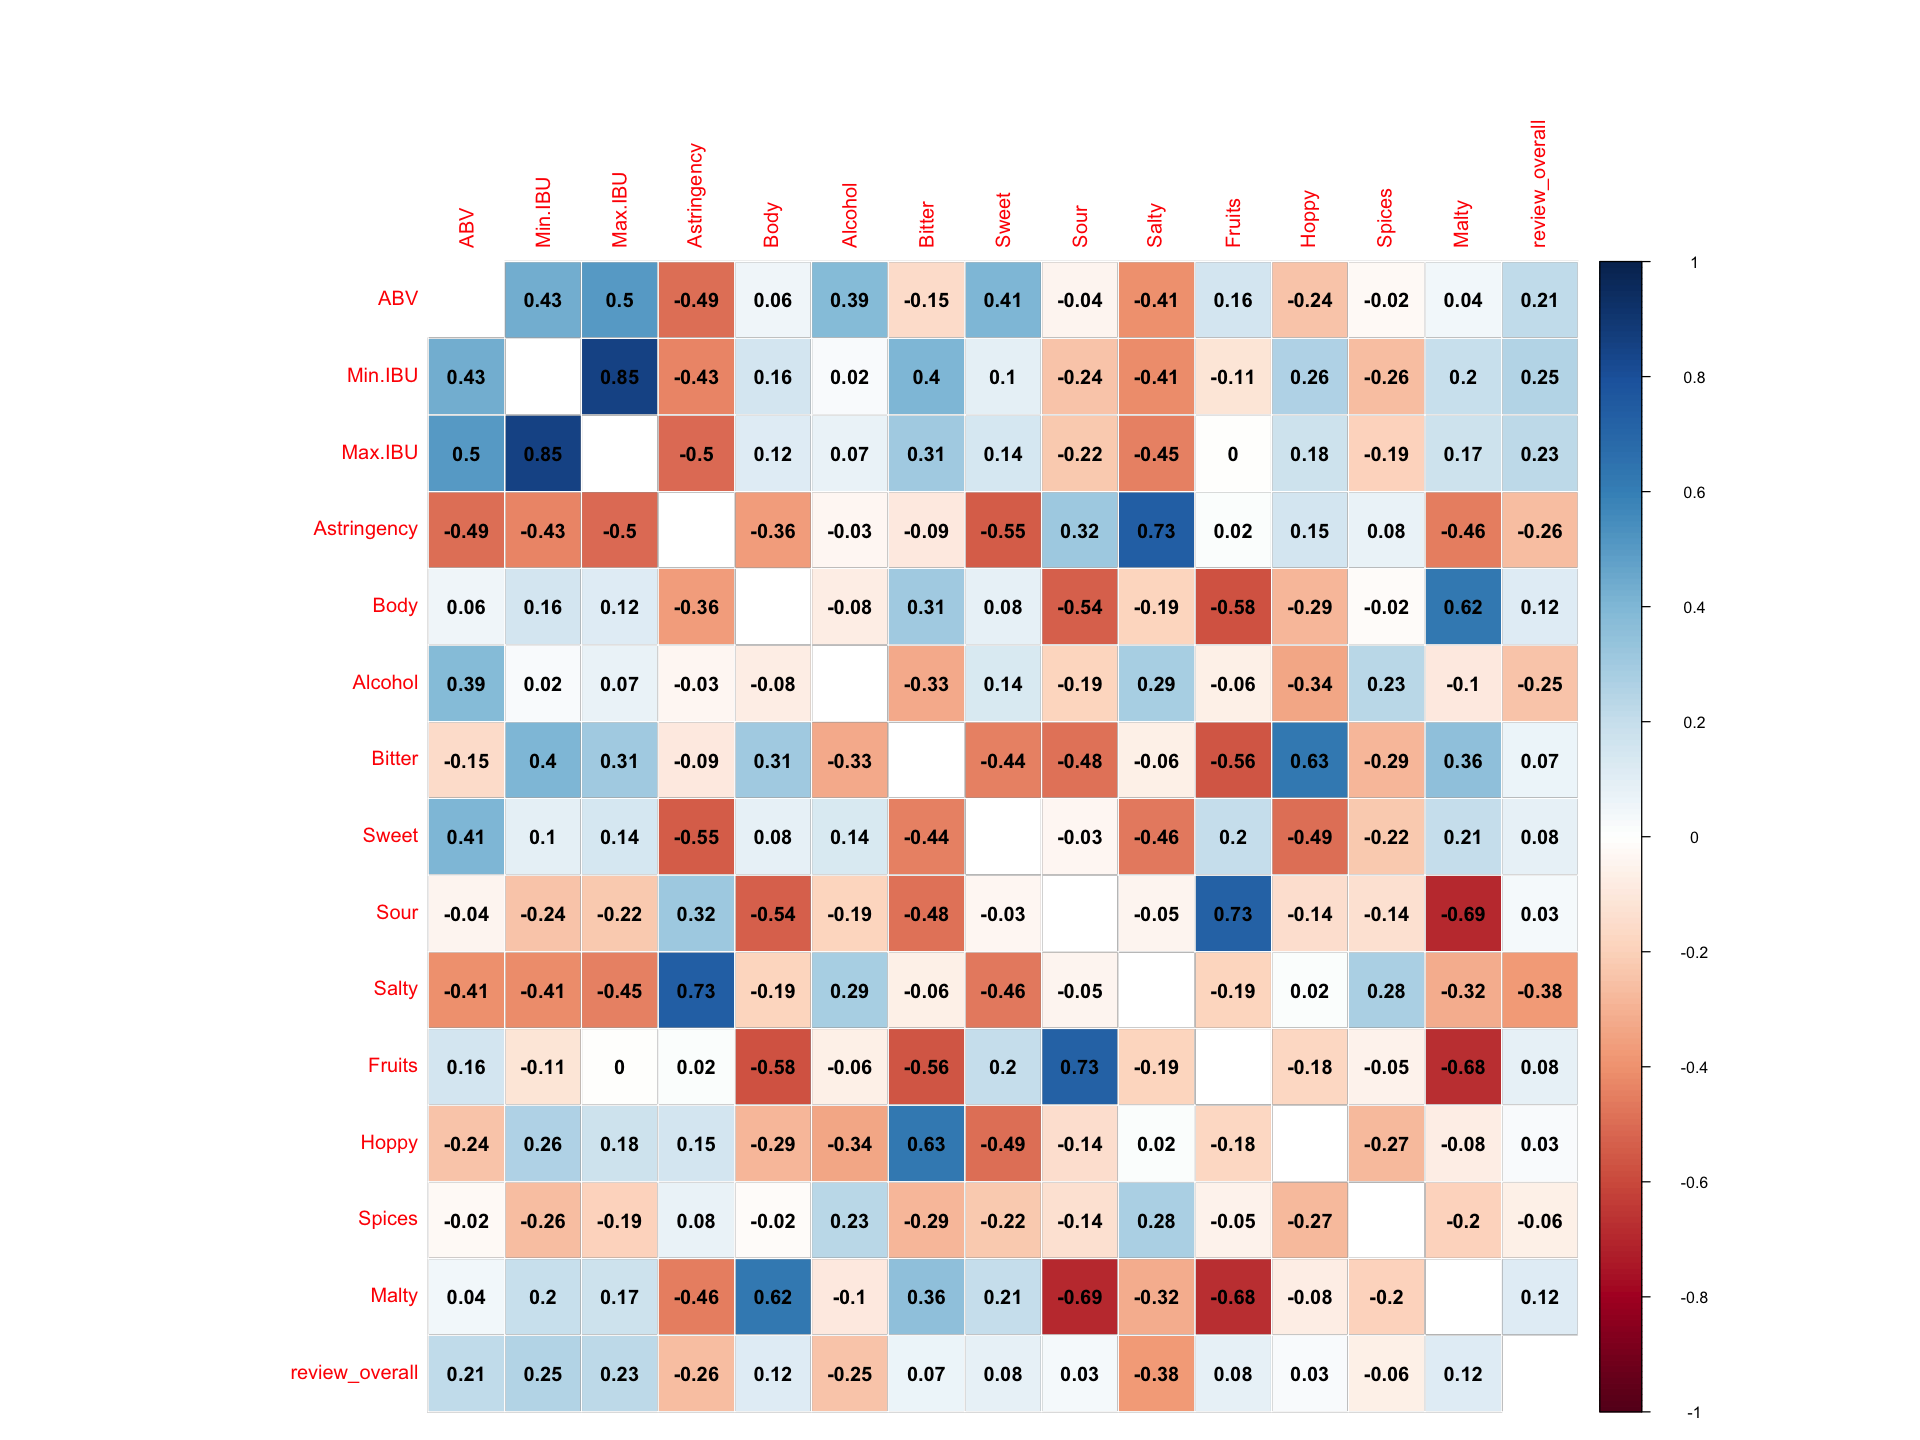

In [39]:
# Creating heat map of correlation between atributes
correlation <- data_for_prediction %>% mutate(review_overall = as.numeric(substr(as.character(review_overall), 2, 2))) %>% cor()
par(bg = 'white')
options(repr.plot.width=16, repr.plot.height=12)
corrplot(correlation, method='color', addCoef.col = 'black',
         number.cex=1, number.digits = 2, diag = FALSE,
         bg='grey', outline='black', addgrid.col='white')

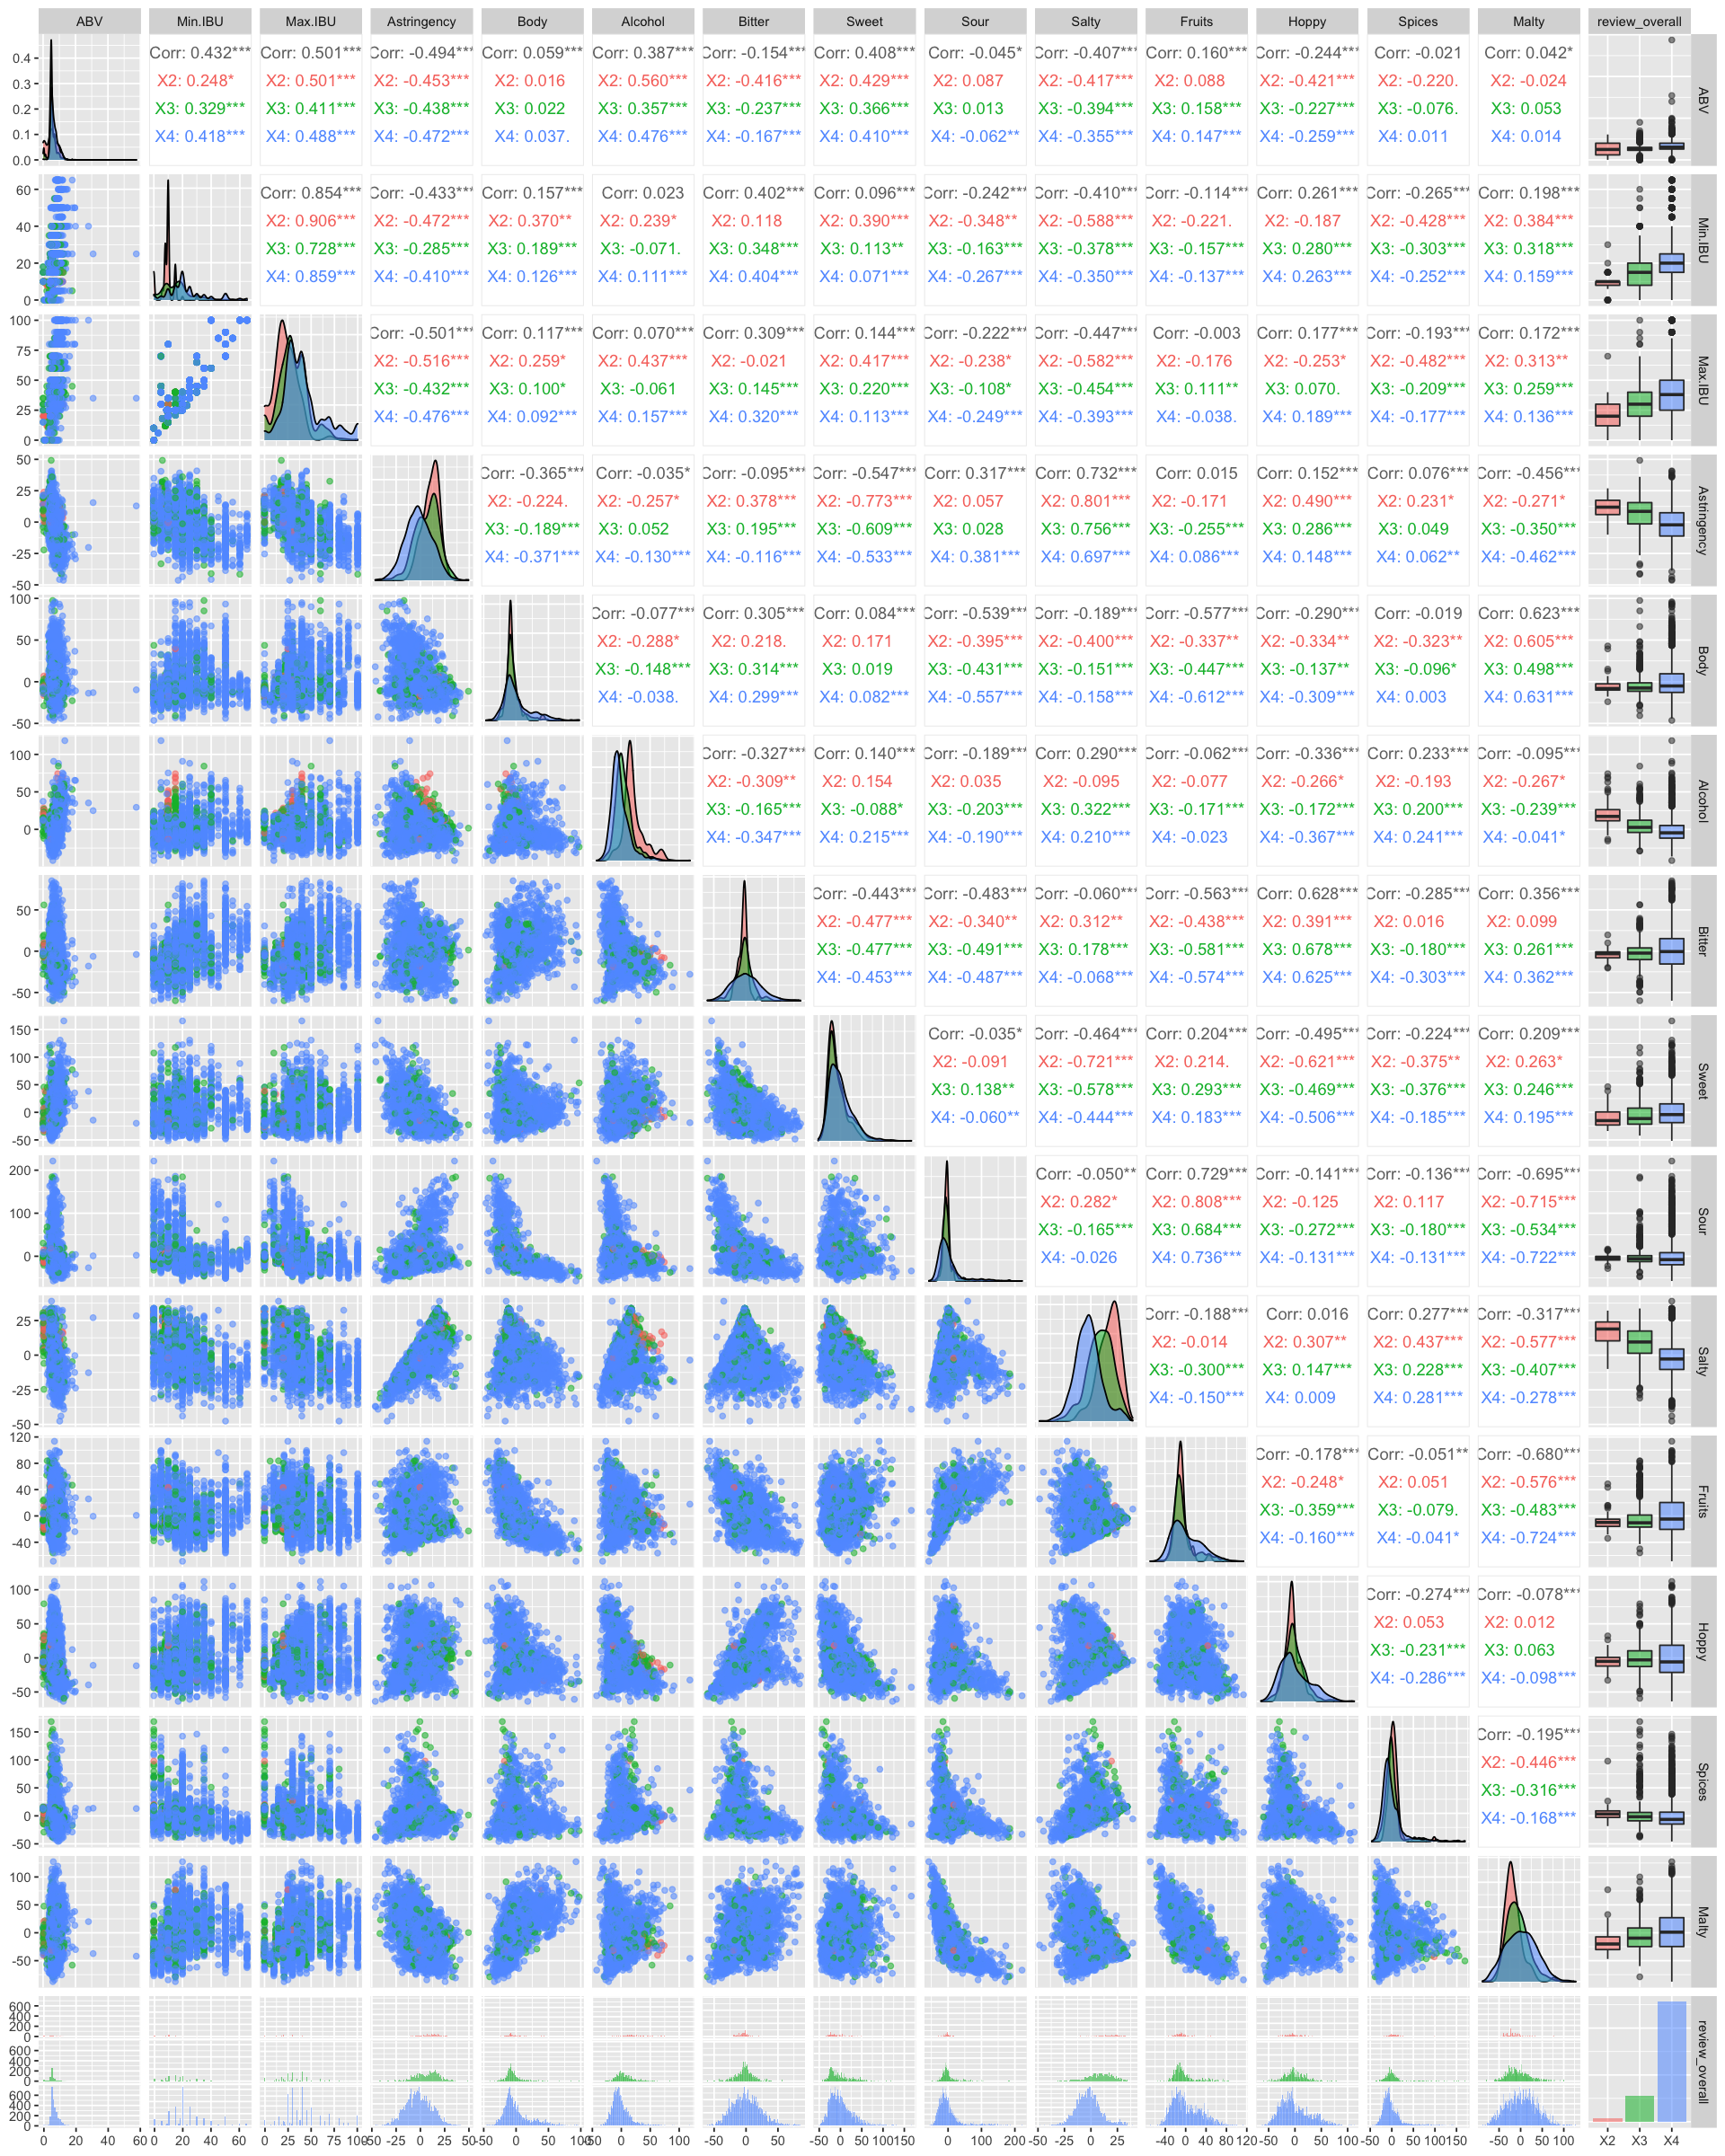

In [40]:
par(bg = 'white')
options(repr.plot.width=16, repr.plot.height=20)
data_for_prediction %>% ggpairs(aes(colour = review_overall, alpha=0.5), lower=list(combo=wrap("facethist", binwidth=1)))

### Conclusions
- The highest possitive correlation with 'review_overall' has the 'Min.IBU' atribute. Next one is a 'Max.IBU' (but it is dependent on 'Min.IBU') and an 'ABV' atribute.
- The highest negative correlation with quality has a 'Salty' atribute. Also 'Astringency' and 'Alcohol' have relatively high negative correlation with 'review_overall'.
- As was assumed before 'Min.IBU' and 'Max.IBU' are highly correlated, so the 'Max.IBU' atribute can be removed.


In [41]:
# Min IBU and Max IBU are not independent, we can remove Max IBU
data_for_prediction <- data_for_prediction %>% dplyr::select(ABV, Min.IBU, Astringency:review_overall)

## Building quality prediction models

### Introduction

In [42]:
# Spliting data on test and train set
set.seed(42)
y <- data_for_prediction$review_overall
test_index <- createDataPartition(y, times = 1, p = 0.3, list = FALSE)
test_set <- data_for_prediction[test_index, ]
train_set <- data_for_prediction[-test_index, ]
test_set_x <- test_set %>% dplyr::select(-review_overall)
train_set_x <- train_set %>% dplyr::select(-review_overall)
test_set_y <- test_set$review_overall
train_set_y <- train_set$review_overall

#### Evaluation metrics
Evaluation metrics that will be used are:
- Overall accuracy
- Sensitivity (Recall)
- Specificity (Precision)
- F1 Score

All the above metrics except weighted F1 score can be calculated with the use of confusion matrix. This matrix, also known as an error matrix is a kind of table that allows visualization of the performance of an algorithm that was used. Binary version of confusion matrix look like this: <br>


| Reference\Predicted| Positve (PN)       | Negative (PN)       |
|:-------------:|:------------------:|:-------------------:|
| **Postive (P)**  | True Positive (TP) | False Negative (FN) |
| **Negative (N)**  | False Positive (FP)| True Negative (TN)  |

But it does not only have application in binary problems, it also exists for multi-class classifiers. Our problem will be broken down into series of binary problems using One-vs-Rest (OVR) approach. We need one score across all classes so weighted average will be applied.
<br><br>Overall accuracy - $ \frac{TP + TN}{P + N}$
<br><br>Sensitivity - $ \frac{TP}{TP + FN}$
<br><br>Specificity - $ \frac{TP}{TP + FP}$
<br><br>F1 Score - $\frac{2TP}{2TP + FP + FN}$ (harmonic mean of specificity and sensitivity).
<br><br>Because the data is imbalanced, the accuracy is not an appropriate metric. To pick the best model during training with grid search the weighted F1 score will be used. This choice is due to the nature of the imbalance, because not many beers are considered bad by consumers.

In [43]:
# Creating function which calculates metric that will be used during training to evaluate model
weighted_f1 <- function (data, lev = NULL, model = NULL) {
  cm <- confusionMatrix(data = data$pred, reference = data$obs)
  precision <- cm$byClass[,'Precision']
  recall  <- cm$byClass[,'Recall']
  f1_val <- (2 * precision * recall) / (precision + recall)
  elem <- as.character(data$obs)
  w <- c(sum(elem == 'X2'), sum(elem == 'X3'), sum(elem == 'X4'))
  f1_val[is.na(f1_val)] <- 0
  f1_val <- weighted.mean(f1_val, w)
  names(f1_val) <- c("F1")
  f1_val
} 

In [44]:
weighted_metrics <- function(confusion_matrix) {
    output <- as.character(train_set_y)
    coeff <- c(sum(output == 'X2'), sum(output == 'X3'), sum(output == 'X4'))
    print(sprintf("Accuracy: %f",confusion_matrix$overall[['Accuracy']]))
    print(sprintf("Precision: %f",weighted.mean(confusion_matrix$byClass[,'Precision'], coeff)))
    print(sprintf("Recall: %f",weighted.mean(confusion_matrix$byClass[,'Recall'], coeff)))
    print(sprintf("F1 Score: %f",weighted.mean(confusion_matrix$byClass[,'F1'], coeff)))
    confusion_matrix
}

### Nearest centroid classifier

In [45]:
set.seed(132)
classifier <- lol.classify.nearestCentroid(train_set_x, train_set_y)

In [46]:
y_hat <- predict(classifier, train_set_x, type = "class") %>% factor(levels = levels(train_set_y))
cm_ncc <- confusionMatrix(data = y_hat, reference = train_set_y)
weighted_metrics(cm_ncc)

[1] "Accuracy: 0.579347"
[1] "Precision: 0.751409"
[1] "Recall: 0.579347"
[1] "F1 Score: 0.638713"


Confusion Matrix and Statistics

          Reference
Prediction   X2   X3   X4
        X2   44  138  144
        X3    5  122  518
        X4    2  134 1130

Overall Statistics
                                      
               Accuracy : 0.579       
                 95% CI : (0.559, 0.6)
    No Information Rate : 0.801       
    P-Value [Acc > NIR] : 1           
                                      
                  Kappa : 0.146       
                                      
 Mcnemar's Test P-Value : <2e-16      

Statistics by Class:

                     Class: X2 Class: X3 Class: X4
Sensitivity             0.8627    0.3096     0.631
Specificity             0.8710    0.7162     0.694
Pos Pred Value          0.1350    0.1891     0.893
Neg Pred Value          0.9963    0.8291     0.318
Prevalence              0.0228    0.1761     0.801
Detection Rate          0.0197    0.0545     0.505
Detection Prevalence    0.1457    0.2883     0.566
Balanced Accuracy       0.8669    0.5129 

- All evaluation metrics have low values on the training set
- Precision has the highest value - high proportion of positive identifications was correct
- From the definition weighted recall and accuracy always have the same value
- It can be assumed that it will be the worst model in the group

### Naive Bayes

In [61]:
trctrl <- trainControl(method = "repeatedcv", number = 5, repeats = 10, summaryFunction = weighted_f1, 
                       search = "grid")
tgrid <- expand.grid(laplace=seq(0, 0.01, len=5), usekernel = c(TRUE, FALSE), adjust=seq(0.13, 0.15, len=10))
set.seed(132)
train_nb <- train(review_overall ~ ., data = as.data.frame(train_set), method = 'naive_bayes',
                  trControl = trctrl, tuneGrid = tgrid, metric = "F1")
train_nb$bestTune

laplace usekernel adjust
12 0       TRUE      0.132

In [62]:
y_hat_nb <- predict(train_nb, train_set_x) %>% factor(levels = levels(train_set_y))
cm_nb <- confusionMatrix(data = y_hat_nb, reference = train_set_y)
weighted_metrics(cm_nb)

[1] "Accuracy: 0.823871"
[1] "Precision: 0.858125"
[1] "Recall: 0.823871"
[1] "F1 Score: 0.835394"


Confusion Matrix and Statistics

          Reference
Prediction   X2   X3   X4
        X2   51   37   45
        X3    0  259  214
        X4    0   98 1533

Overall Statistics
                                        
               Accuracy : 0.824         
                 95% CI : (0.807, 0.839)
    No Information Rate : 0.801         
    P-Value [Acc > NIR] : 0.00337       
                                        
                  Kappa : 0.533         
                                        
 Mcnemar's Test P-Value : < 2e-16       

Statistics by Class:

                     Class: X2 Class: X3 Class: X4
Sensitivity             1.0000     0.657     0.855
Specificity             0.9625     0.884     0.780
Pos Pred Value          0.3835     0.548     0.940
Neg Pred Value          1.0000     0.923     0.573
Prevalence              0.0228     0.176     0.801
Detection Rate          0.0228     0.116     0.685
Detection Prevalence    0.0595     0.211     0.729
Balanced Accuracy      

- Best model uses laplace smoothing coefficient equal to 0, with kernel and adjust equal to 0.132
- Model is better than nearest centroid classifier
- Nearly 0.84 weighted F1 score
- High precision and recall
- Naive Bayes assumes features independece - it is not present in this data

### k-nearest neighbors

In [63]:
trctrl <- trainControl(method = "repeatedcv", number = 5, repeats = 10, summaryFunction = weighted_f1, 
                       search = "grid")
set.seed(132)
train_knn <- caret::train(review_overall ~ ., data = as.data.frame(train_set), method = "knn",
                   trControl=trctrl,
                   preProcess = c("center", "scale"),
                   tuneGrid = data.frame(k = seq(1, 25)), metric = "F1")

[1] "Best tune k: 9"

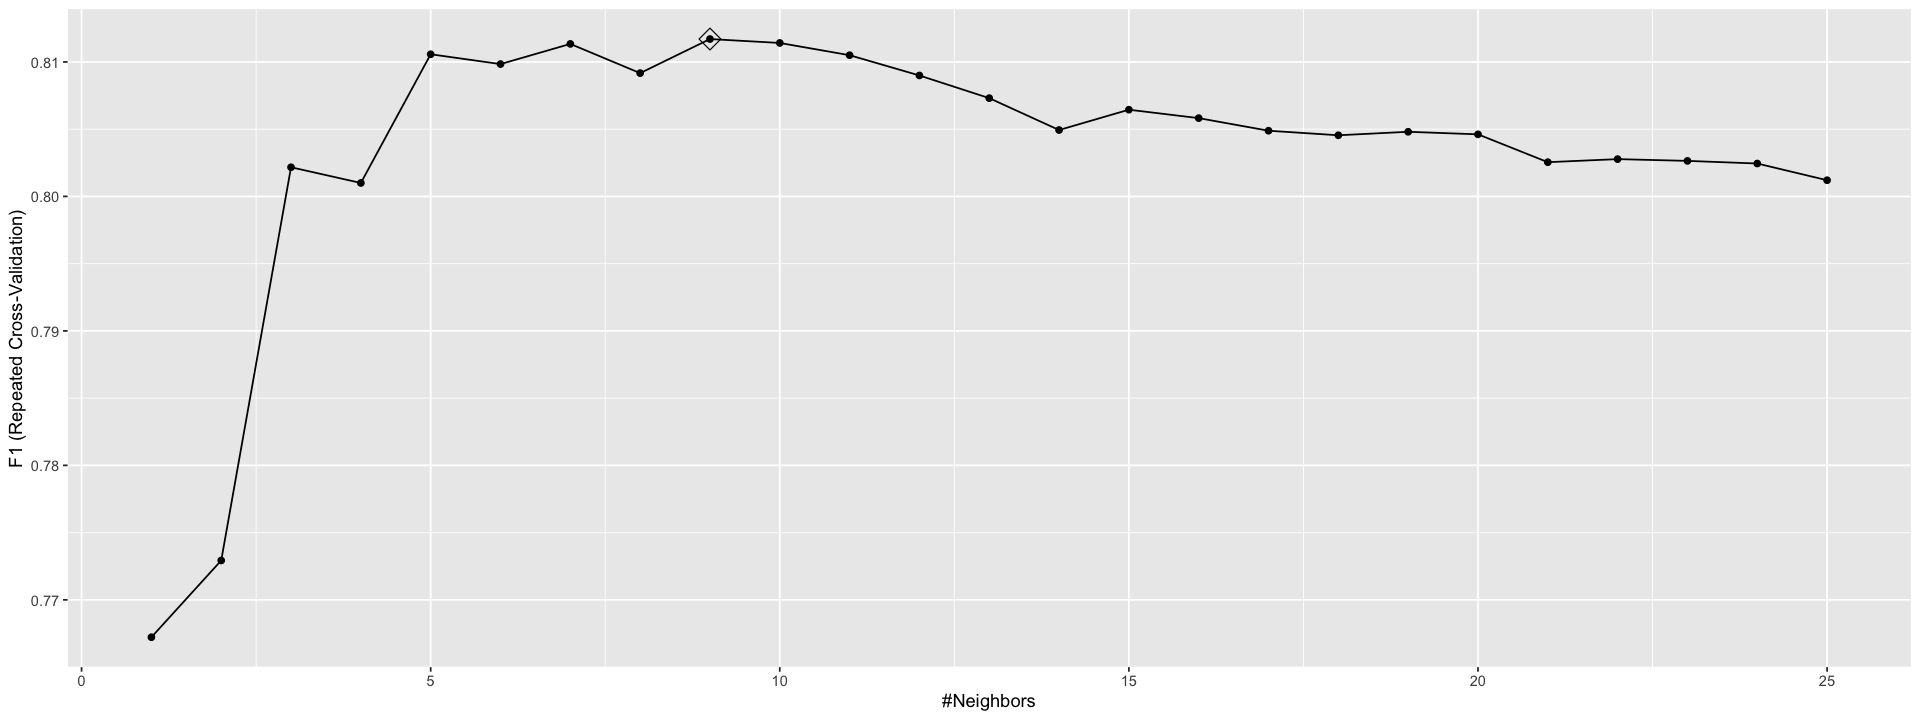

In [64]:
sprintf("Best tune k: %g", train_knn[['bestTune']]$k)
options(repr.plot.width=16, repr.plot.height=6)
ggplot(train_knn, highlight = TRUE)

In [65]:
# Once we optimize our algorithm, we can fit it to the entire dataset
fit_knn <- knn3(review_overall ~ ., data = train_set,  k = train_knn$bestTune$k)
y_hat_knn <- predict(fit_knn, train_set_x, type = 'class') %>% factor(levels = levels(train_set_y))
cm_knn <- confusionMatrix(data = y_hat_knn, reference = train_set_y)
weighted_metrics(cm_knn)

[1] "Accuracy: 0.846223"
[1] "Precision: 0.825455"
[1] "Recall: 0.846223"
[1] "F1 Score: 0.825134"


Confusion Matrix and Statistics

          Reference
Prediction   X2   X3   X4
        X2    9    5    0
        X3   29  149   57
        X4   13  240 1735

Overall Statistics
                                        
               Accuracy : 0.846         
                 95% CI : (0.831, 0.861)
    No Information Rate : 0.801         
    P-Value [Acc > NIR] : 2.05e-08      
                                        
                  Kappa : 0.429         
                                        
 Mcnemar's Test P-Value : < 2e-16       

Statistics by Class:

                     Class: X2 Class: X3 Class: X4
Sensitivity            0.17647    0.3782     0.968
Specificity            0.99771    0.9533     0.431
Pos Pred Value         0.64286    0.6340     0.873
Neg Pred Value         0.98111    0.8776     0.771
Prevalence             0.02280    0.1761     0.801
Detection Rate         0.00402    0.0666     0.776
Detection Prevalence   0.00626    0.1051     0.889
Balanced Accuracy      

- Best knn model is with k equal to 9
- Model is better than NCC but slightly worse than Naive Bayes
- Model has problems with prediction for class 'X2' (class with the lowest quantity of examples)

### Classification tree

In [52]:
set.seed(132)
trctrl <- trainControl(method = "repeatedcv", number = 5, repeats = 10, summaryFunction = weighted_f1, 
                       search = "grid")
train_rpart <- train(review_overall ~ ., 
                     method = "rpart",
                     tuneGrid = data.frame(cp = seq(0, 0.01, len = 25)),
                     trControl = trctrl,
                     data = train_set, metric = "F1")

cp     
20 0.00792

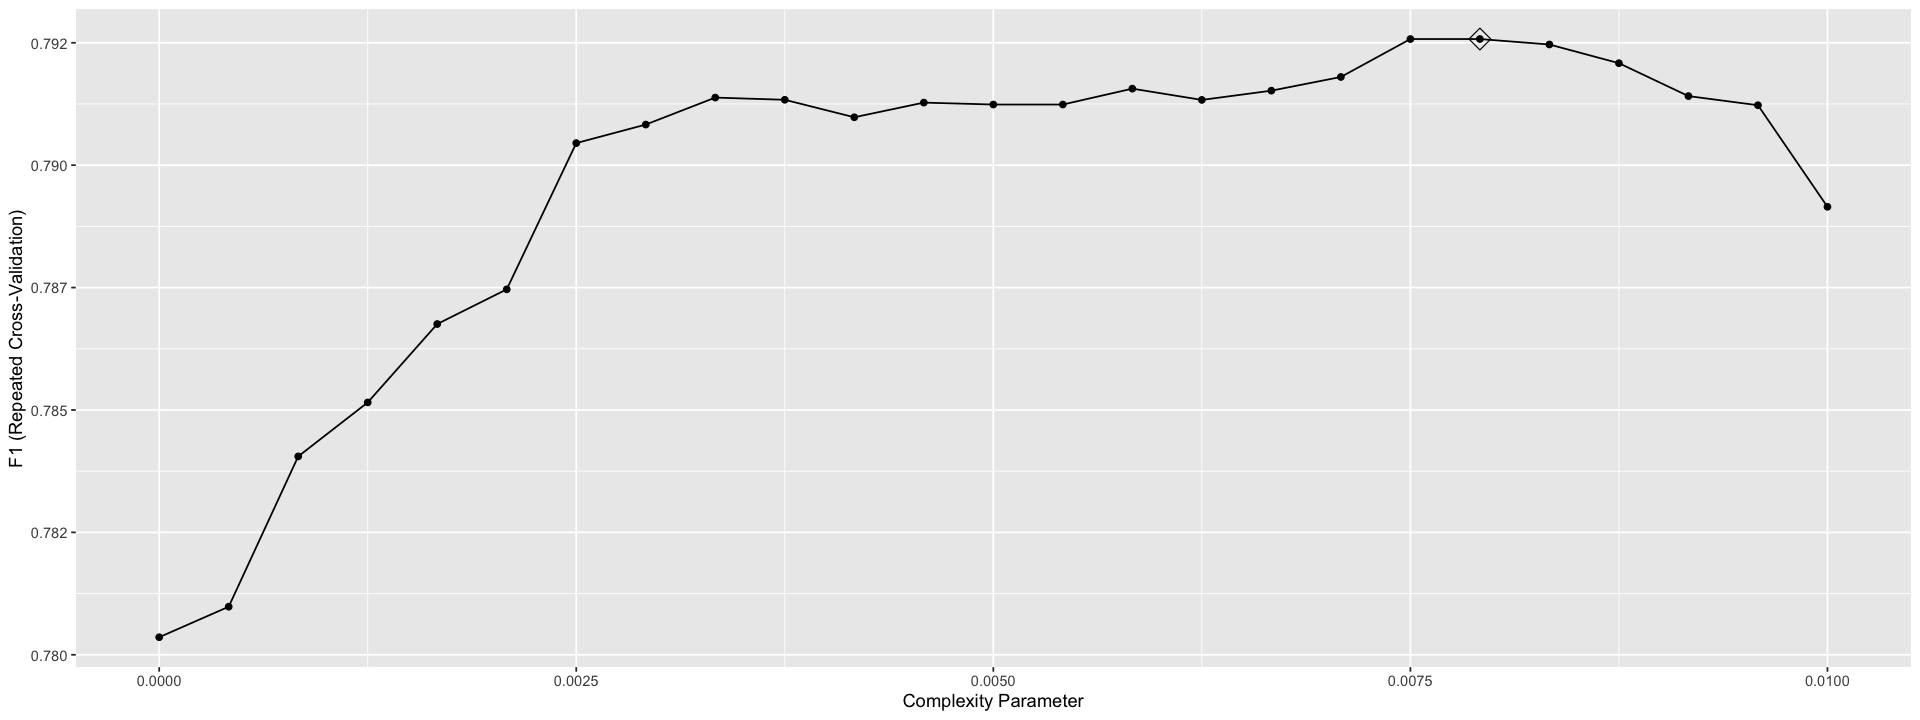

In [81]:
train_rpart$bestTune
ggplot(train_rpart, highlight = TRUE)

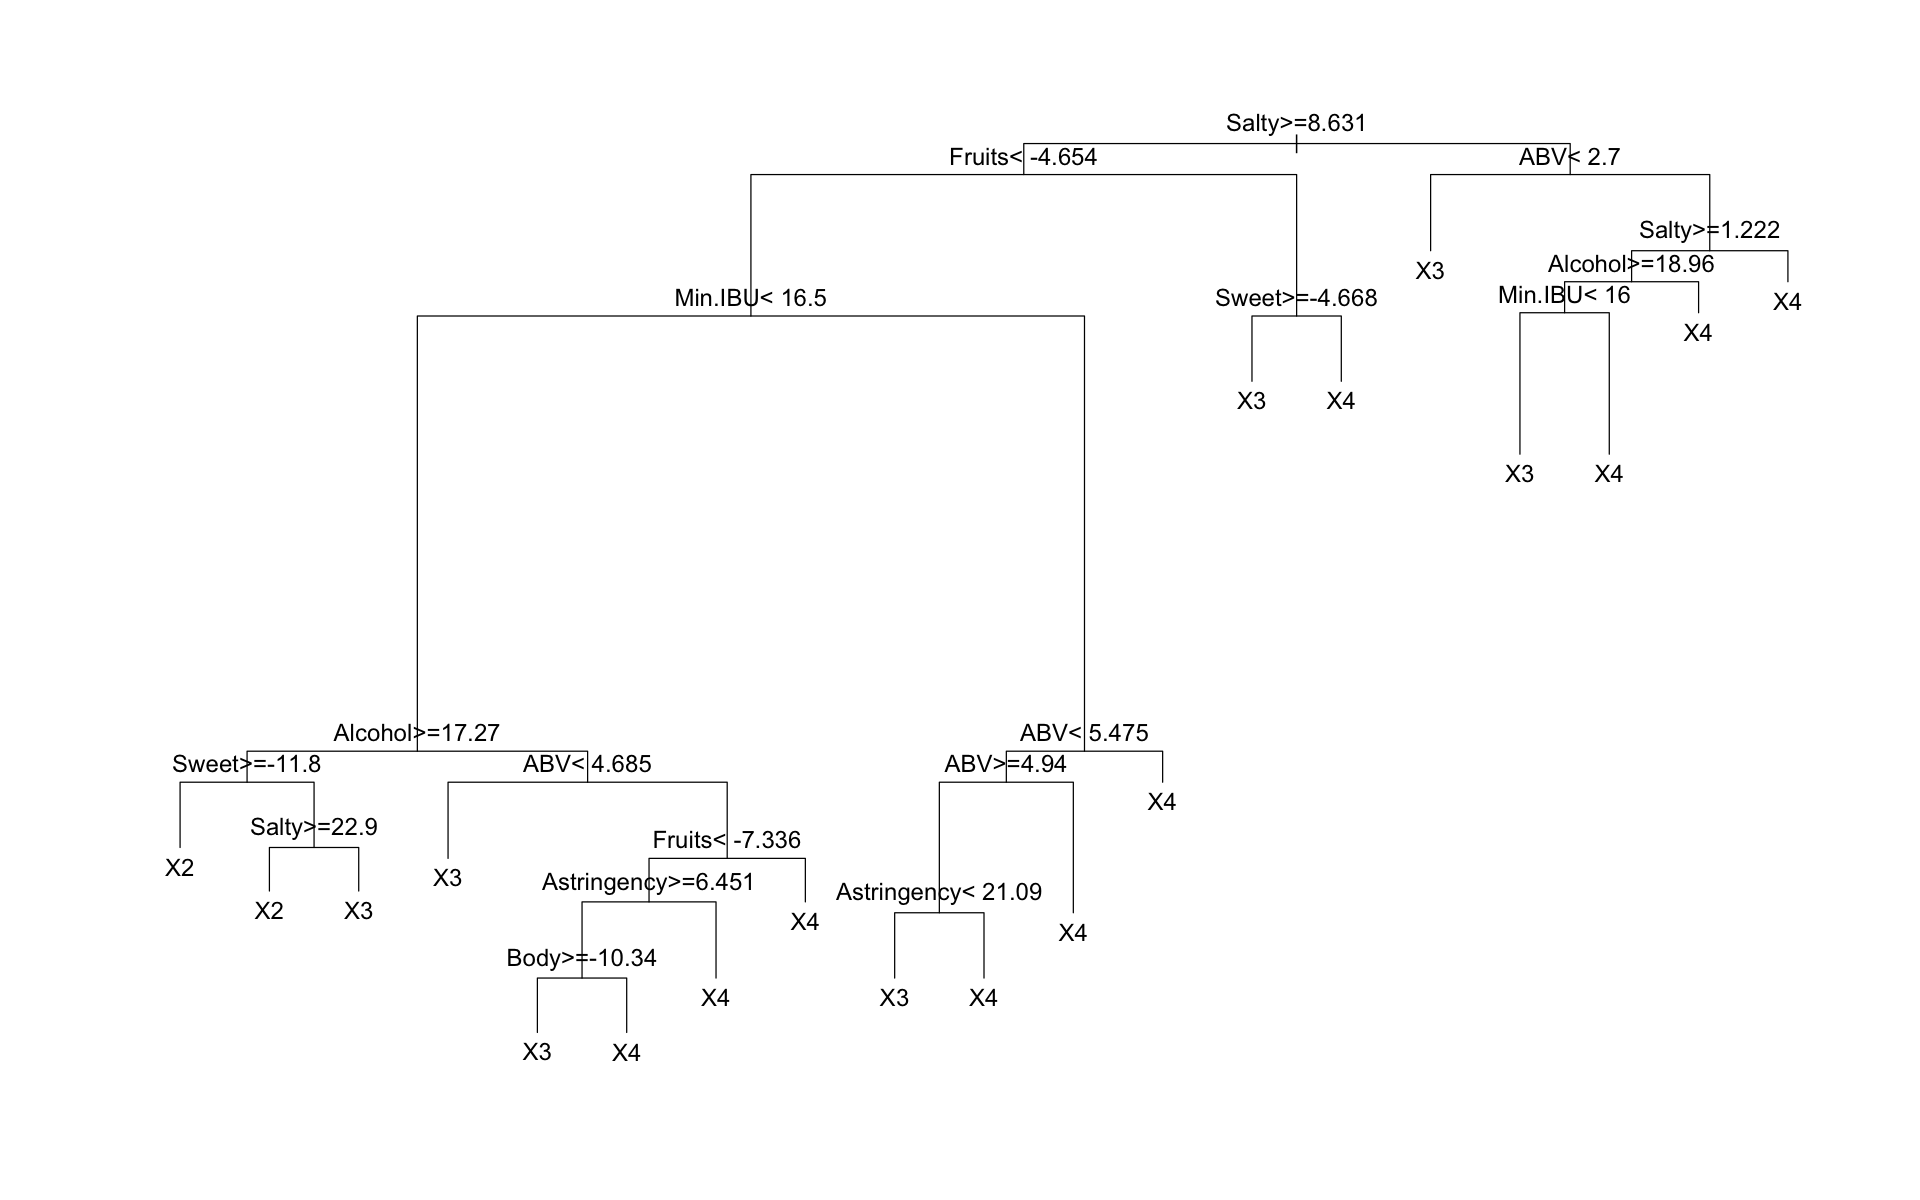

In [54]:
par(bg = 'white')
options(repr.plot.width=16, repr.plot.height=10)
plot(train_rpart$finalModel, margin = 0.01)
text(train_rpart$finalModel, cex = 1.2)

In [55]:
y_hat_tree <- predict(train_rpart, train_set_x)
cm_tree <- confusionMatrix(y_hat_tree, train_set_y)
weighted_metrics(cm_tree)

[1] "Accuracy: 0.859186"
[1] "Precision: 0.843181"
[1] "Recall: 0.859186"
[1] "F1 Score: 0.842388"


Confusion Matrix and Statistics

          Reference
Prediction   X2   X3   X4
        X2   18    8    2
        X3   24  163   49
        X4    9  223 1741

Overall Statistics
                                        
               Accuracy : 0.859         
                 95% CI : (0.844, 0.873)
    No Information Rate : 0.801         
    P-Value [Acc > NIR] : 4.51e-13      
                                        
                  Kappa : 0.487         
                                        
 Mcnemar's Test P-Value : < 2e-16       

Statistics by Class:

                     Class: X2 Class: X3 Class: X4
Sensitivity            0.35294    0.4137     0.972
Specificity            0.99543    0.9604     0.479
Pos Pred Value         0.64286    0.6907     0.882
Neg Pred Value         0.98506    0.8846     0.807
Prevalence             0.02280    0.1761     0.801
Detection Rate         0.00805    0.0729     0.778
Detection Prevalence   0.01252    0.1055     0.882
Balanced Accuracy      

- Complexity parameter for the best model is equal to 0.00792
- Main split parameter is 'Salty' which has the highest negative correlation with quality
- The best model so far
- Performance on the smallest class (X2) is between Naive Bayes and knn
- The most common split feature is 'ABV'

### Random Forest

In [83]:
set.seed(132)
trctrl <- trainControl(method = "repeatedcv", number = 5, repeats = 10, summaryFunction = weighted_f1,
                       search = "grid")
fit_rf <- train(review_overall ~ ., method = "rf",
                trControl = trctrl, tuneLength  = 15,
                data = train_set, metric = "F1")

note: only 12 unique complexity parameters in default grid. Truncating the grid to 12 .



mtry
6 7

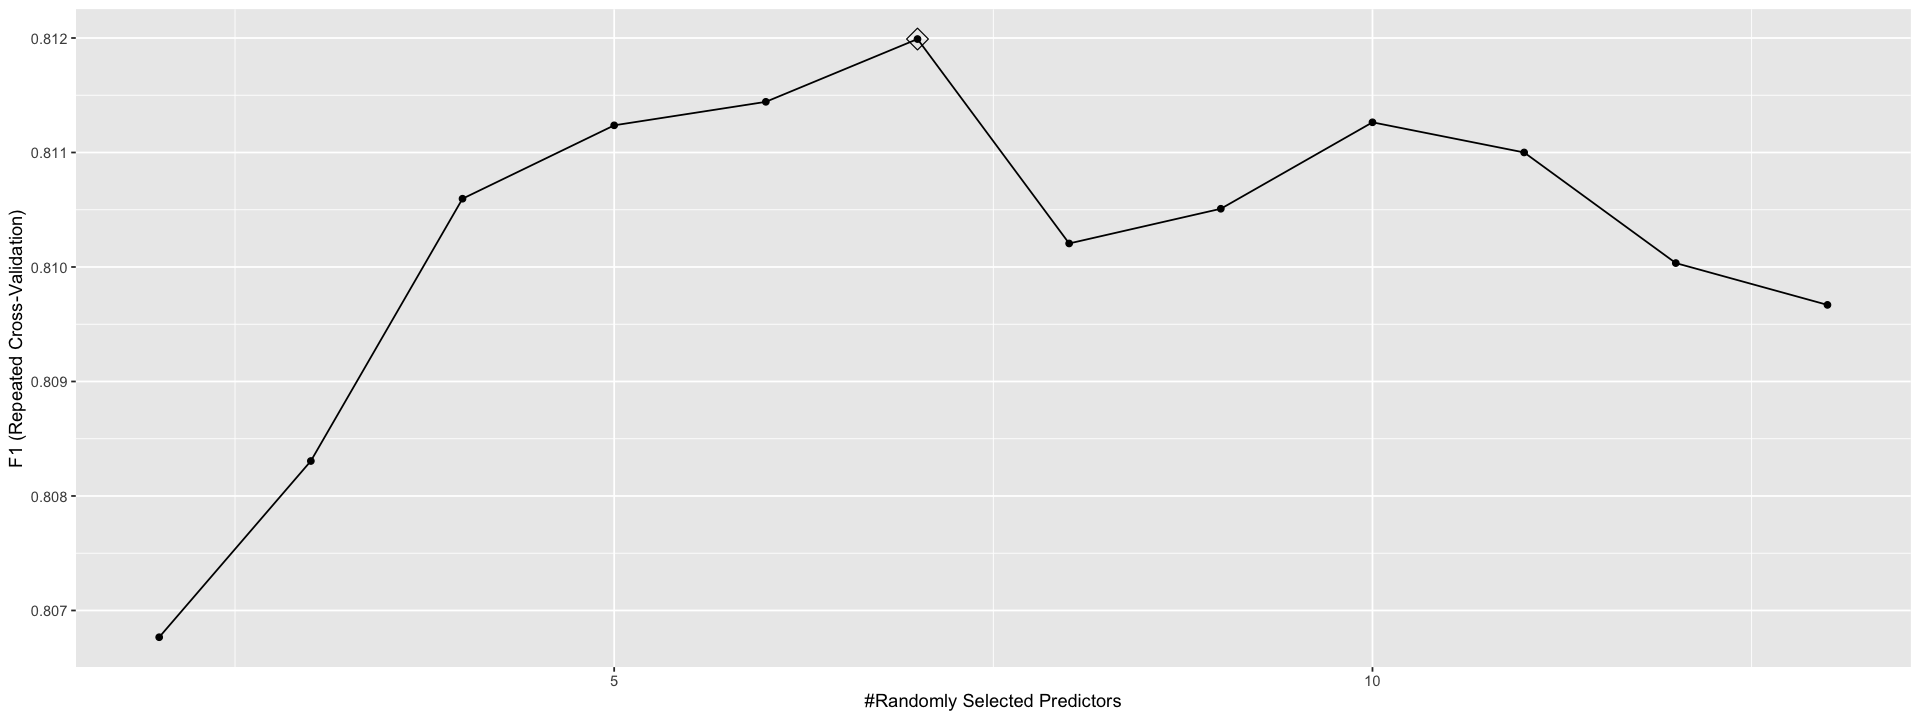

In [98]:
fit_rf$bestTune
ggplot(fit_rf, highlight = TRUE)

In [85]:
y_hat_rf <- predict(fit_rf, train_set_x)
cm_rf <- confusionMatrix(data = y_hat_rf, reference = train_set_y)
weighted_metrics(cm_rf)

[1] "Accuracy: 1.000000"
[1] "Precision: 1.000000"
[1] "Recall: 1.000000"
[1] "F1 Score: 1.000000"


Confusion Matrix and Statistics

          Reference
Prediction   X2   X3   X4
        X2   51    0    0
        X3    0  394    0
        X4    0    0 1792

Overall Statistics
                                    
               Accuracy : 1         
                 95% CI : (0.998, 1)
    No Information Rate : 0.801     
    P-Value [Acc > NIR] : <2e-16    
                                    
                  Kappa : 1         
                                    
 Mcnemar's Test P-Value : NA        

Statistics by Class:

                     Class: X2 Class: X3 Class: X4
Sensitivity             1.0000     1.000     1.000
Specificity             1.0000     1.000     1.000
Pos Pred Value          1.0000     1.000     1.000
Neg Pred Value          1.0000     1.000     1.000
Prevalence              0.0228     0.176     0.801
Detection Rate          0.0228     0.176     0.801
Detection Prevalence    0.0228     0.176     0.801
Balanced Accuracy       1.0000     1.000     1.000

- The best model on training set
- Evaluation metrics are perfect - equal to 1
- The only ensemble algorithm among used methods
- The ensemble of best performing model - decision tree
- Model performs best with "mtry" parameter set to 7 (number of variable is randomly collected to be sampled at each split time)

## Evaluation models on test set

### Nearest centroid classifier

In [91]:
y_hat <- predict(classifier, test_set_x, type = "class") %>% factor(levels = levels(test_set_y))
cm_ncc <- confusionMatrix(data = y_hat, reference = test_set_y)
weighted_metrics(cm_ncc)

[1] "Accuracy: 0.593750"
[1] "Precision: 0.770773"
[1] "Recall: 0.593729"
[1] "F1 Score: 0.655172"


Confusion Matrix and Statistics

          Reference
Prediction  X2  X3  X4
        X2  14  54  70
        X3   6  67 210
        X4   2  48 489

Overall Statistics
                                        
               Accuracy : 0.594         
                 95% CI : (0.562, 0.625)
    No Information Rate : 0.801         
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : 0.179         
                                        
 Mcnemar's Test P-Value : <2e-16        

Statistics by Class:

                     Class: X2 Class: X3 Class: X4
Sensitivity             0.6364    0.3964     0.636
Specificity             0.8678    0.7269     0.738
Pos Pred Value          0.1014    0.2367     0.907
Neg Pred Value          0.9903    0.8493     0.335
Prevalence              0.0229    0.1760     0.801
Detection Rate          0.0146    0.0698     0.509
Detection Prevalence    0.1437    0.2948     0.561
Balanced Accuracy       0.7521    0

- As assumed model is the worst
- What is interesting is that it performs better on average, than on training set
- Predicts class 'X2' the best among tested models

### Naive Bayes

In [92]:
y_hat_nb <- predict(train_nb, test_set_x) %>% factor(levels = levels(test_set_y))
cm_nb <- confusionMatrix(data = y_hat_nb, reference = test_set_y)
weighted_metrics(cm_nb)

[1] "Accuracy: 0.758333"
[1] "Precision: 0.790245"
[1] "Recall: 0.758346"
[1] "F1 Score: 0.772020"


Confusion Matrix and Statistics

          Reference
Prediction  X2  X3  X4
        X2  10  21  17
        X3   5  78 112
        X4   7  70 640

Overall Statistics
                                       
               Accuracy : 0.758        
                 95% CI : (0.73, 0.785)
    No Information Rate : 0.801        
    P-Value [Acc > NIR] : 0.999        
                                       
                  Kappa : 0.338        
                                       
 Mcnemar's Test P-Value : 2.88e-05     

Statistics by Class:

                     Class: X2 Class: X3 Class: X4
Sensitivity             0.4545    0.4615     0.832
Specificity             0.9595    0.8521     0.597
Pos Pred Value          0.2083    0.4000     0.893
Neg Pred Value          0.9868    0.8810     0.469
Prevalence              0.0229    0.1760     0.801
Detection Rate          0.0104    0.0813     0.667
Detection Prevalence    0.0500    0.2031     0.747
Balanced Accuracy       0.7070    0.6568    

- Model is the second worst in the group
- It is not working on class 'X2' as good as when it was used on training set
- Problem can be a dependence between data features

### k-nearest neighbors

In [93]:
y_hat_knn <- predict(fit_knn, test_set_x, type = 'class') %>% factor(levels = levels(test_set_y))
cm_knn <- confusionMatrix(data = y_hat_knn, reference = test_set_y)
weighted_metrics(cm_knn)

[1] "Accuracy: 0.831250"
[1] "Precision: 0.801438"
[1] "Recall: 0.831306"
[1] "F1 Score: 0.808588"


Confusion Matrix and Statistics

          Reference
Prediction  X2  X3  X4
        X2   1   2   2
        X3  10  62  32
        X4  11 105 735

Overall Statistics
                                        
               Accuracy : 0.831         
                 95% CI : (0.806, 0.854)
    No Information Rate : 0.801         
    P-Value [Acc > NIR] : 0.00959       
                                        
                  Kappa : 0.377         
                                        
 Mcnemar's Test P-Value : 6.37e-11      

Statistics by Class:

                     Class: X2 Class: X3 Class: X4
Sensitivity            0.04545    0.3669     0.956
Specificity            0.99574    0.9469     0.393
Pos Pred Value         0.20000    0.5962     0.864
Neg Pred Value         0.97801    0.8750     0.688
Prevalence             0.02292    0.1760     0.801
Detection Rate         0.00104    0.0646     0.766
Detection Prevalence   0.00521    0.1083     0.886
Balanced Accuracy      0.52060    0

In [97]:
cm_knn$byClass

Sensitivity Specificity Pos Pred Value Neg Pred Value Precision
Class: X2 0.0455      0.996       0.200          0.978          0.200    
Class: X3 0.3669      0.947       0.596          0.875          0.596    
Class: X4 0.9558      0.393       0.864          0.688          0.864    
          Recall F1     Prevalence Detection Rate Detection Prevalence
Class: X2 0.0455 0.0741 0.0229     0.00104        0.00521             
Class: X3 0.3669 0.4542 0.1760     0.06458        0.10833             
Class: X4 0.9558 0.9074 0.8010     0.76562        0.88646             
          Balanced Accuracy
Class: X2 0.521            
Class: X3 0.657            
Class: X4 0.674

- Knn model works better on average than the two above
- It has problems with predicting class 'X2'
- Recall for 'X2' class is nearly 0

### Classification tree

In [94]:
y_hat_tree <- predict(train_rpart, test_set_x)
cm_tree <- confusionMatrix(y_hat_tree, test_set_y)
weighted_metrics(cm_tree)

[1] "Accuracy: 0.822917"
[1] "Precision: 0.791209"
[1] "Recall: 0.822963"
[1] "F1 Score: 0.799244"


Confusion Matrix and Statistics

          Reference
Prediction  X2  X3  X4
        X2   2   9   1
        X3  12  52  32
        X4   8 108 736

Overall Statistics
                                        
               Accuracy : 0.823         
                 95% CI : (0.797, 0.847)
    No Information Rate : 0.801         
    P-Value [Acc > NIR] : 0.0472        
                                        
                  Kappa : 0.347         
                                        
 Mcnemar's Test P-Value : 3.26e-10      

Statistics by Class:

                     Class: X2 Class: X3 Class: X4
Sensitivity            0.09091    0.3077     0.957
Specificity            0.98934    0.9444     0.393
Pos Pred Value         0.16667    0.5417     0.864
Neg Pred Value         0.97890    0.8646     0.694
Prevalence             0.02292    0.1760     0.801
Detection Rate         0.00208    0.0542     0.767
Detection Prevalence   0.01250    0.1000     0.887
Balanced Accuracy      0.54012    0

- Model is good but not the best
- Also works poorly on the smallest class
- Slightly better on smallest class than knn but worse for other classes

### Random Forest

In [95]:
y_hat_rf <- predict(fit_rf, test_set_x)
cm_rf <- confusionMatrix(data = y_hat_rf, reference = test_set_y)
weighted_metrics(cm_rf)

[1] "Accuracy: 0.842708"
[1] "Precision: 0.819053"
[1] "Recall: 0.842755"
[1] "F1 Score: 0.822683"


Confusion Matrix and Statistics

          Reference
Prediction  X2  X3  X4
        X2   3   6   2
        X3  11  64  25
        X4   8  99 742

Overall Statistics
                                        
               Accuracy : 0.843         
                 95% CI : (0.818, 0.865)
    No Information Rate : 0.801         
    P-Value [Acc > NIR] : 0.000525      
                                        
                  Kappa : 0.424         
                                        
 Mcnemar's Test P-Value : 1.16e-10      

Statistics by Class:

                     Class: X2 Class: X3 Class: X4
Sensitivity            0.13636    0.3787     0.965
Specificity            0.99147    0.9545     0.440
Pos Pred Value         0.27273    0.6400     0.874
Neg Pred Value         0.97998    0.8779     0.757
Prevalence             0.02292    0.1760     0.801
Detection Rate         0.00313    0.0667     0.773
Detection Prevalence   0.01146    0.1042     0.884
Balanced Accuracy      0.56392    0

- The best on average model of all
- Around 0.82 F1 score on the test set
- Also works not that well with class 'X2'

## Conclusions

- The data set is imbalanced, therefore it is troublesome to create a model which performs well on all classes
- Based on average, the best performing model is the Random Forest
- Based on average, the worst performing model is the Nearest Centroid Classifier
- The Nearest Centroid Classifier is best suited to categorize 'X2' class
- The imbalance does not come from the lack of data, people tend to rate beers as good than as bad or medium, thus performing much better on classes 'X3' and 'X4' does not mean the models are wrong